In [1]:
from sklearn.decomposition import PCA
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.mixture import GMM
import subprocess
from scipy import stats
import itertools
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=12, usetex=True)
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
import matplotlib.patches as patches

In [2]:
# función para convertir los datos de LONLAT a formato legible por el computador
def conversion(old):
    direction = {'N':-1, 'S':1, 'E': -1, 'W':1} # diccionario
    new = old.replace('\xc2\xb0',' ').replace('\'',' ').replace('"',' ')
    new = new.split() # separa grados, minutos, segundos, orientación en una lista de 4 objetos
    new_dir = new.pop() # extrae la orientación
    return (int(new[0])+int(new[1])/60.0+int(float(new[2]))/3600.0) * direction[new_dir]

In [3]:
# mapa de Colombia
colvec=np.loadtxt('colvecdep.txt')

In [4]:
# solo si esta muy chinchoso por deprecation warnings
import warnings
warnings.filterwarnings("ignore")

In [5]:
def data_reduction(dataname):
    reso=300
    from matplotlib.patches import Rectangle
    from mpl_toolkits.mplot3d import Axes3D
    setup_text_plots(fontsize=16, usetex=True)
    truel=False
    trueb=False
    trueh=False
    trued=False
    if dataname=="lluvia.csv":
        varname="Precipitation"
        uname="mm/mo"
        truel=True
    if dataname=="brillo.csv":
        varname="Sunshine Duration"
        uname="h/d"
        trueb=True
    if dataname=="humedad.csv":
        varname="Relative Humidity"
        uname="\%"
        trueh=True
    if dataname=="diaslluvia.csv":
        varname="Rain Days"
        uname="d/mo"
        trued=True
    df=pd.read_csv(dataname)
    AH=df.as_matrix(columns=df.columns[8:20])
    pca = PCA(0.95)  
    XprojH = pca.fit_transform(AH)
    Ncomp = XprojH.shape[1]
    print "No. of stations that measure this variable = ",XprojH.shape[0],", No. of PCA components (95%) = ",XprojH.shape[1]
    print "Explained variance ratio = ", pca.explained_variance_ratio_.sum(axis=0)
    print "Explained variance ratio per component = ", pca.explained_variance_ratio_

    # para que las gráficas se vean con los mismos ejes
    xmin=min(XprojH[:, 0])
    xmax=max(XprojH[:, 0])
    ymin=min(XprojH[:, 1])
    ymax=max(XprojH[:, 1])

    # conversión de formato LATLON
    latH=np.zeros(len(df.LATITUD))
    lonH=np.zeros(len(df.LATITUD))
    codeH=np.zeros(len(df.LATITUD))
    altH=np.zeros(len(df.LATITUD))
    for i in range(len(df.LATITUD)):
        latH[i]=conversion(df.LATITUD[i])
        lonH[i]=conversion(df.LONGITUD[i])
        codeH[i]=df.CODIGO[i]
        altH[i]=df.ELEV[i]
        
# Esqueleto de evaluación de BIC para el agrupamiento para cada variable climatologica
# BIC - Bayesian Information Criterion
# De esta manera vemos cual es número ideal de componentes y el mejor método para el agrupamiento
# http://scikit-learn.org/stable/modules/mixture.html
# 
# El agrupamiento seleccionado para cada variable es el que minimiza el BIC 
# H, full, 2 components
# D, full, 6 components
# B, tied, 5 components
# L, full, 11 components

    cv_types = ['spherical', 'tied', 'diag', 'full']
    Xbic=XprojH
    compo=15
    BIC=np.zeros((compo+1,4))
    kik=0
    for cv_type in cv_types:
        for kcomp in np.arange(compo)+1:        
            gmm = GMM(kcomp, covariance_type=cv_type, random_state=0)
            gmm.fit(Xbic)
            BIC[kcomp,kik]=gmm.bic(Xbic)
            bicold=gmm.bic(Xbic)
        kik+=1    
    compx=np.arange(compo+1)[1:]
    BIC=BIC[1:]
    for i, cv_type in zip(range(4),cv_types):
        plt.plot(compx,BIC[:,i],label=cv_type)
    plt.legend(loc='upper center')
    plt.xlim(1,compo)
    plt.xlabel("No. of Clusters")
    plt.ylabel("BIC")
    plt.title("BIC for %s clustering" % varname)
    plt.xticks(np.arange(min(compx), max(compx)+1, 1.0))
    if trueh :
        plt.savefig('pasp/bich.eps', dpi=reso)
        plt.savefig('pasp/bich.pdf', dpi=reso)
    if truel :
        plt.savefig('pasp/bicl.eps', dpi=reso)
        plt.savefig('pasp/bicl.pdf', dpi=reso)
    if trued :
        plt.savefig('pasp/bicd.eps', dpi=reso)
        plt.savefig('pasp/bicd.pdf', dpi=reso)
    if trueb :
        plt.savefig('pasp/bicb.eps', dpi=reso)
        plt.savefig('pasp/bicb.pdf', dpi=reso)

    plt.show()

    minperm=np.argmin(BIC,axis=0)
    bicsmin=np.array([])
    for i in range(len(minperm)):
        bicsmin=np.append(bicsmin,BIC[minperm[i],i])
    covt=cv_types[np.argmin(bicsmin)]
    kcomp=minperm[np.argmin(bicsmin)]+1
    print "GMM covariance method:", covt, ", No. of GMM clusters = ", kcomp


    # Mixtura gaussiana para kcomp clusters
    gmm = GMM(kcomp, covariance_type=covt, random_state=0)
    gmm.fit(XprojH)
    cluster_labelH = gmm.predict(XprojH)
    if XprojH.shape[1] == 2 :
        plt.scatter(XprojH[:,0],XprojH[:,1])
        plt.xlabel("Component 1")
        plt.ylabel("Component 2")
        plt.savefig('pasp/pcah.eps', dpi=reso)
        plt.savefig('pasp/pcah.pdf', dpi=reso)
        fig, ax = plt.subplots()
        ax.scatter(XprojH[:,0],XprojH[:,1],c=cluster_labelH,cmap='jet')
        plt.xlabel("Component 1")
        plt.ylabel("Component 2")
        plt.title("%s, %i clusters" %(varname,kcomp))
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        plt.savefig('pasp/ldeh.eps', dpi=reso)
        plt.savefig('pasp/ldeh.pdf', dpi=reso)
    if XprojH.shape[1] > 2 :
        fig = plt.figure()
        ax = Axes3D(fig)
        ax.scatter(XprojH[:,0],XprojH[:,1],XprojH[:,2],s=20,c=cluster_labelH,cmap='jet')
        ax.set_xlabel('Component 1',fontsize=14)
        ax.set_ylabel('Component 2',fontsize=14)
        ax.set_zlabel('Component 3',fontsize=14)
        ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        for t in ax.zaxis.get_major_ticks(): t.label.set_fontsize(10)
        for t in ax.xaxis.get_major_ticks(): t.label.set_fontsize(10)
        for t in ax.yaxis.get_major_ticks(): t.label.set_fontsize(10)
        plt.title("%s, %i clusters" %(varname,kcomp))        
        if truel :
            plt.savefig('pasp/ldel.eps', dpi=reso,transparent=True)
            plt.savefig('pasp/ldel.pdf', dpi=reso,transparent=True)            
        if trued :
            plt.savefig('pasp/lded.eps', dpi=reso,transparent=True)
            plt.savefig('pasp/lded.pdf', dpi=reso,transparent=True)            
        if trueb :
            plt.savefig('pasp/ldeb.eps', dpi=reso,transparent=True)
            plt.savefig('pasp/ldeb.pdf', dpi=reso,transparent=True)            
        plt.show()
    # Se hace una gráfica para cada cluster
    colors = iter(plt.cm.brg(np.linspace(0, 1, kcomp)))
    for kk in range(kcomp):
        D=np.zeros([sum(cluster_labelH==kk),Ncomp])
        B=np.zeros([sum(cluster_labelH==kk),12])
        LAT=np.zeros([sum(cluster_labelH==kk)])
        LON=np.zeros([sum(cluster_labelH==kk)])
        ALTH=np.zeros([sum(cluster_labelH==kk)])
        i=0
        for k in range(len(cluster_labelH)):
            if cluster_labelH[k]==kk:
                B[i]=AH[k]
                D[i]=XprojH[k]
                LAT[i]=latH[k]
                LON[i]=lonH[k]
                ALTH[i]=df.ELEV[k]
                i=i+1
        print "Number of stations in cluster %i is %i" %(kk,i)
        
        
        plt.figure(figsize=(13,5))
        setup_text_plots(fontsize=16, usetex=True)

        ii=0

        xx=np.arange(12)
        plt.subplot(1, 2, ii+1)
        
        #plt.plot(np.arange(12),datamonth,color=next(colors),label=mylabel)
        myc=next(colors)
        plt.errorbar(xx,B.mean(axis=0),yerr=B.std(axis=0),label='Cluster %i'%(kk+1),ecolor='k',color=myc)
        plt.plot(B.mean(axis=0),color=myc)
        kloc=4
        if trueb:
            kloc=1
        plt.legend(loc=kloc,frameon=False)
        plt.xlabel('Month')
        plt.ylabel('%s, Av. =%5.f %s' % (varname,B.mean(axis=0).mean(),uname))
        xlabels=['J','F','M','A','M','J','J','A','S','O','N','D','']
        plt.xticks(range(0,13),xlabels, fontsize = 10)
        plt.subplot(1, 2, ii+2)
        plt.scatter(-LON,-LAT,c=ALTH,cmap='cubehelix')
        plt.colorbar(label='Altitude, Mean Alt. = %i m' % ALTH.mean())
        plt.scatter(colvec[:,0],colvec[:,1],s=0.01,c='k')
        leg1 = Rectangle((0, 0), 0, 0, alpha=0.0)
        plt.legend([leg1], ["%i stations" %i], handlelength=0,loc='upper right',frameon=False)
        plt.xlabel(r"Longitude ($^\circ$)")
        plt.ylabel(r"Latitude ($^\circ$)")
        plt.axis('equal')
        plt.axis([-80,-65,-5,14])
        if trueh :            
            plt.savefig('pasp/gmmh%i.eps'%kk, dpi=reso)
            plt.savefig('pasp/gmmh%i.pdf'%kk, dpi=reso)            
        if truel :
            plt.savefig('pasp/gmml%i.eps'%kk, dpi=reso)
            plt.savefig('pasp/gmml%i.pdf'%kk, dpi=reso)           
        if trued :
            plt.savefig('pasp/gmmd%i.eps'%kk, dpi=reso)
            plt.savefig('pasp/gmmd%i.pdf'%kk, dpi=reso)            
        if trueb :
            plt.savefig('pasp/gmmb%i.eps'%kk, dpi=reso)
            plt.savefig('pasp/gmmb%i.pdf'%kk, dpi=reso)            
        plt.show()
    # Esto es para graficarlos todos en una misma gráfica de LATLON. Ahora LAT y LON son arrays
    LATH=np.zeros([len(cluster_labelH),kcomp])
    LONH=np.zeros([len(cluster_labelH),kcomp])
    ALTH=np.zeros([len(cluster_labelH),kcomp])
    CODH=np.zeros([len(cluster_labelH),kcomp])
    for kk in range(kcomp):
        i=0
        for k in range(len(df)):
            if cluster_labelH[k]==kk:
                LATH[i,kk]=latH[k]
                LONH[i,kk]=lonH[k]
                ALTH[i,kk]=df.ELEV[k]
                CODH[i,kk]=df.CODIGO[k]
                i=i+1
    return LATH,LONH,ALTH,CODH,cluster_labelH,latH,lonH,codeH,altH

No. of stations that measure this variable =  336 , No. of PCA components (95%) =  3
Explained variance ratio =  0.968881031972
Explained variance ratio per component =  [ 0.8163693   0.11928973  0.03322201]


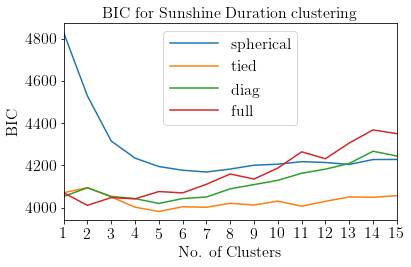

GMM covariance method: tied , No. of GMM clusters =  5


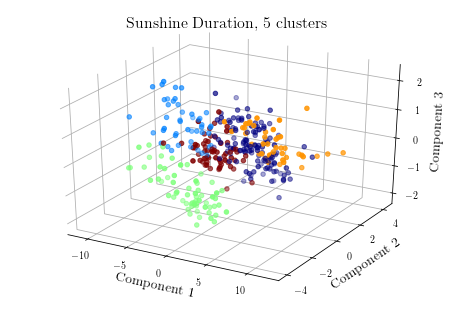

Number of stations in cluster 0 is 121


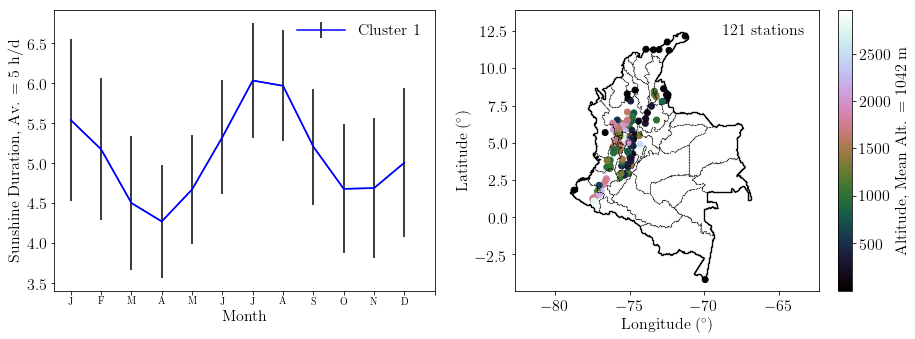

Number of stations in cluster 1 is 46


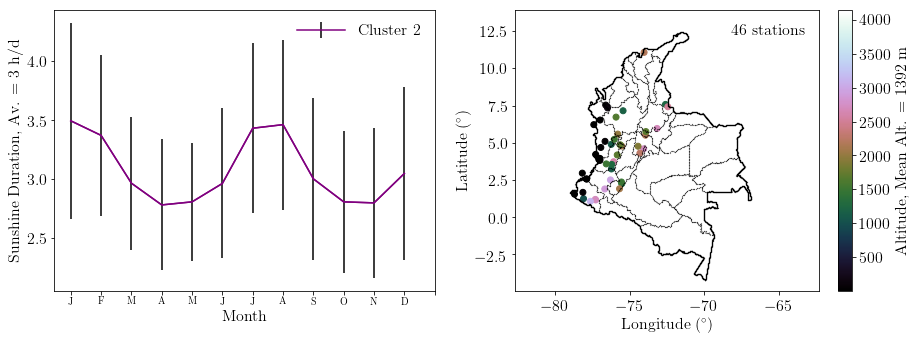

Number of stations in cluster 2 is 63


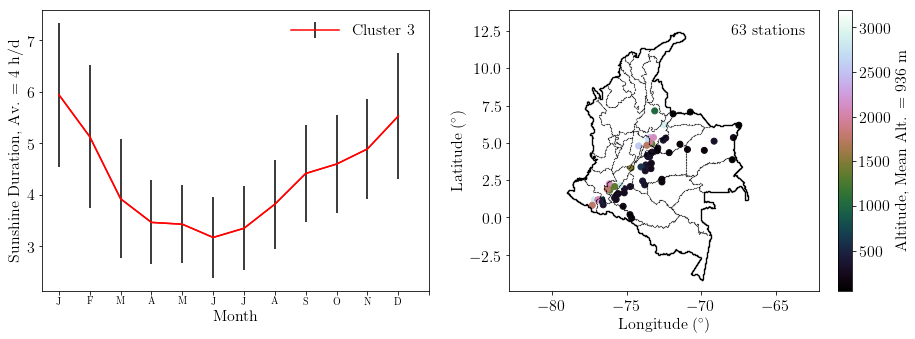

Number of stations in cluster 3 is 43


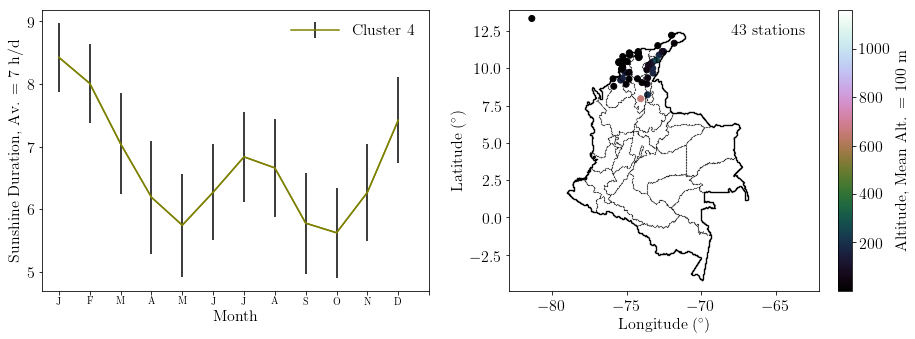

Number of stations in cluster 4 is 63


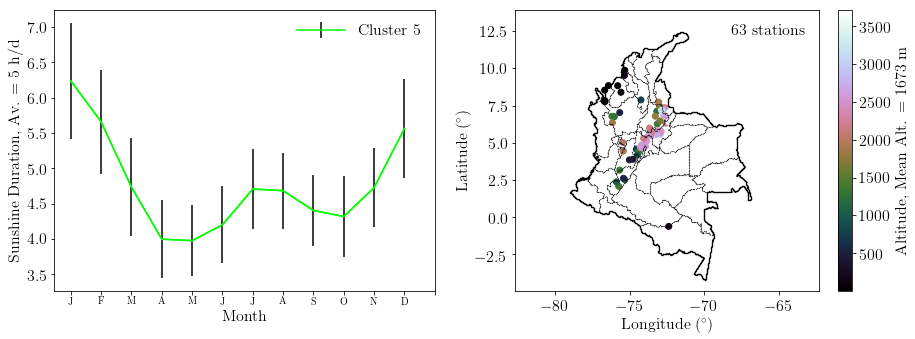

In [6]:
LATB,LONB,ALTB,CODB,cluster_labelB,latB,lonB,codeB,altB=data_reduction('brillo.csv')

No. of stations that measure this variable =  445 , No. of PCA components (95%) =  2
Explained variance ratio =  0.959021220933
Explained variance ratio per component =  [ 0.84050377  0.11851745]


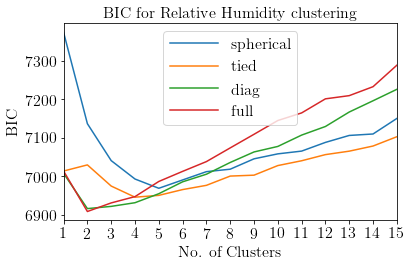

GMM covariance method: full , No. of GMM clusters =  2
Number of stations in cluster 0 is 258


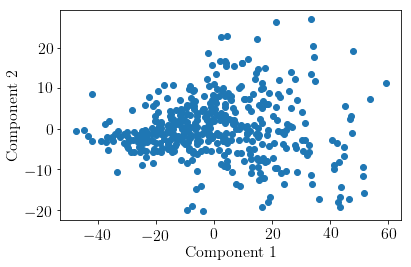

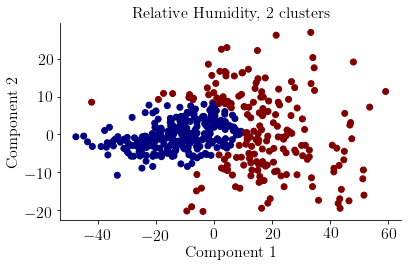

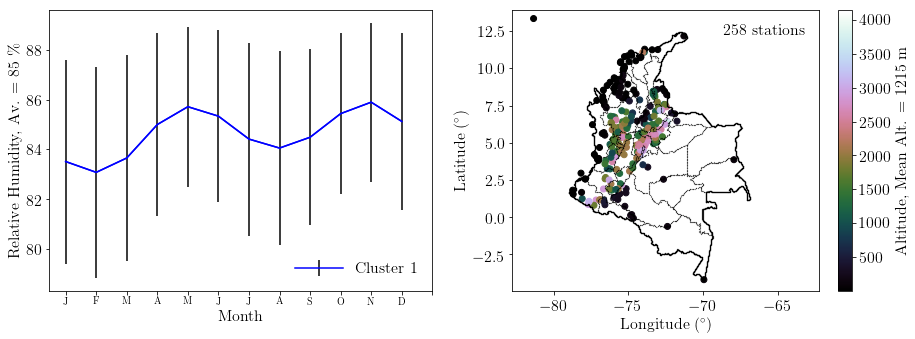

Number of stations in cluster 1 is 187


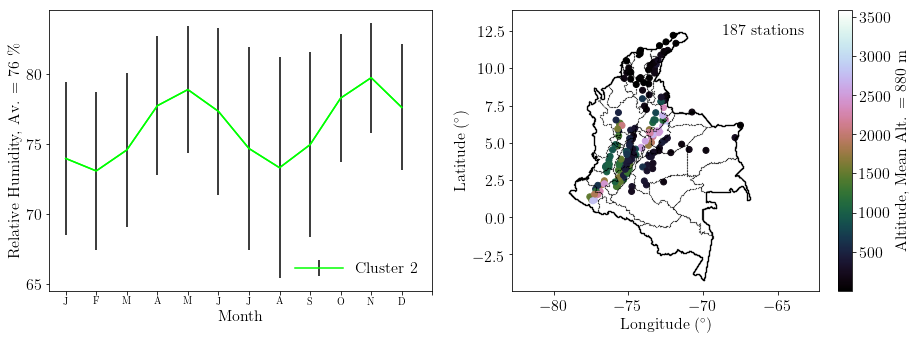

In [7]:
LATH,LONH,ALTH,CODH,cluster_labelH,latH,lonH,codeH,altH=data_reduction('humedad.csv')

No. of stations that measure this variable =  2046 , No. of PCA components (95%) =  3
Explained variance ratio =  0.959578491041
Explained variance ratio per component =  [ 0.78211583  0.13516064  0.04230202]


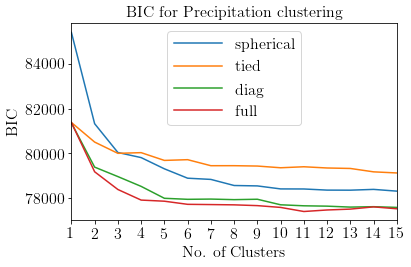

GMM covariance method: full , No. of GMM clusters =  11


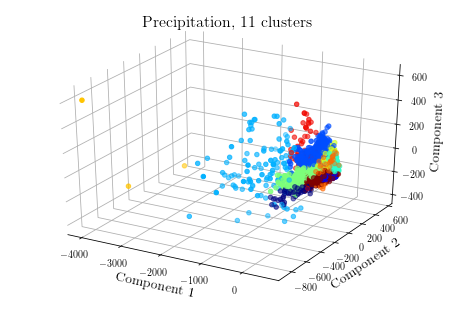

Number of stations in cluster 0 is 67


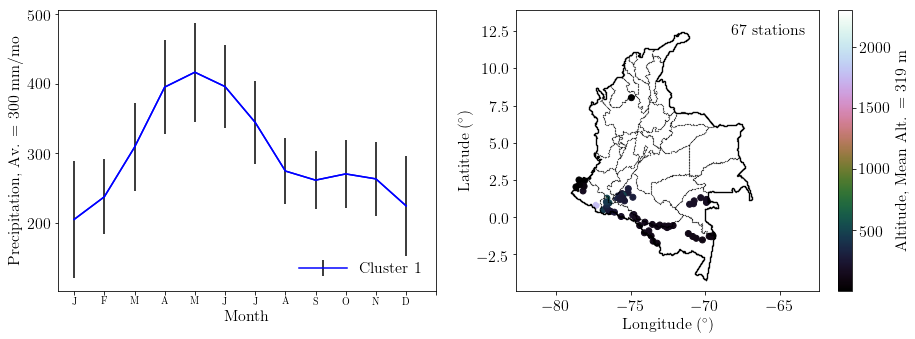

Number of stations in cluster 1 is 194


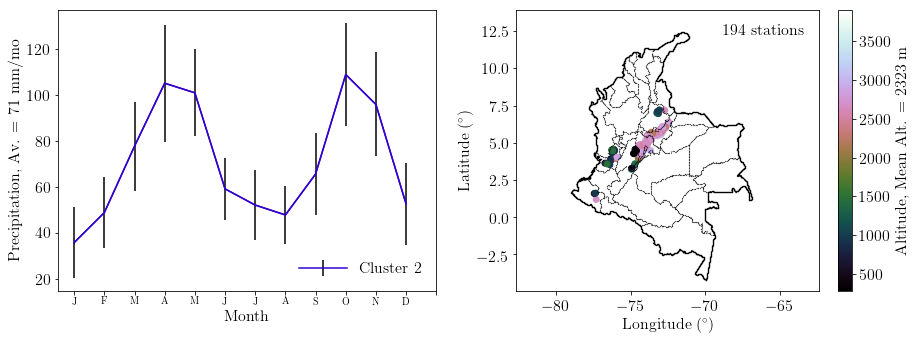

Number of stations in cluster 2 is 269


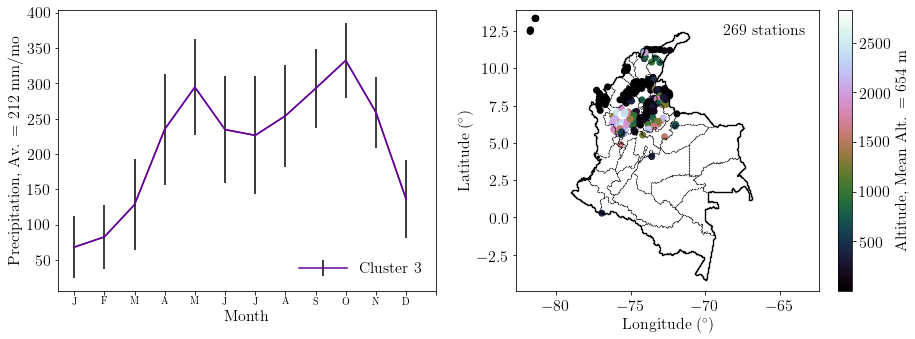

Number of stations in cluster 3 is 114


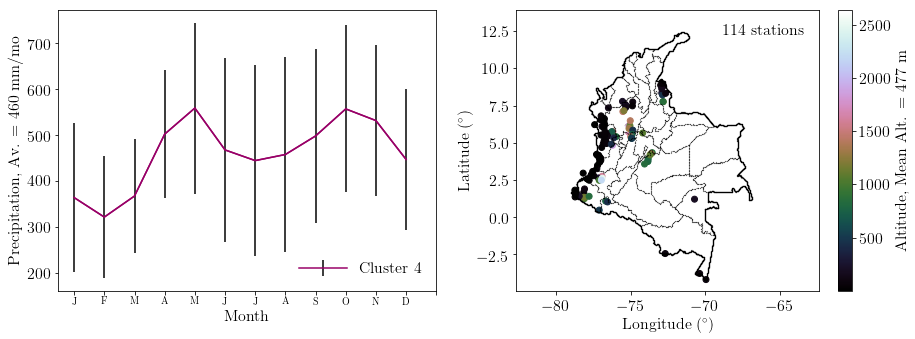

Number of stations in cluster 4 is 244


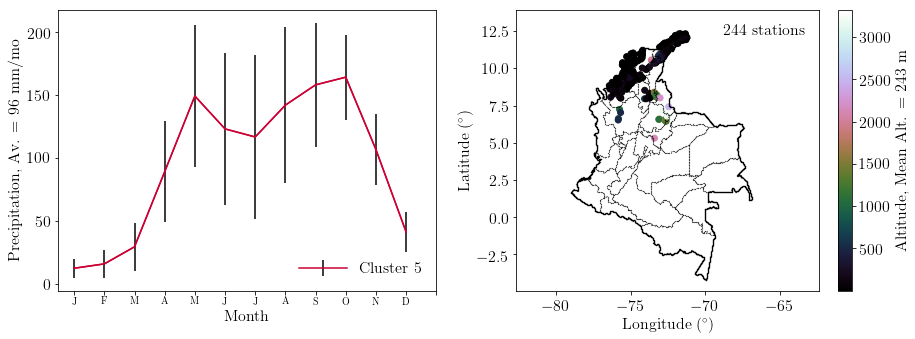

Number of stations in cluster 5 is 295


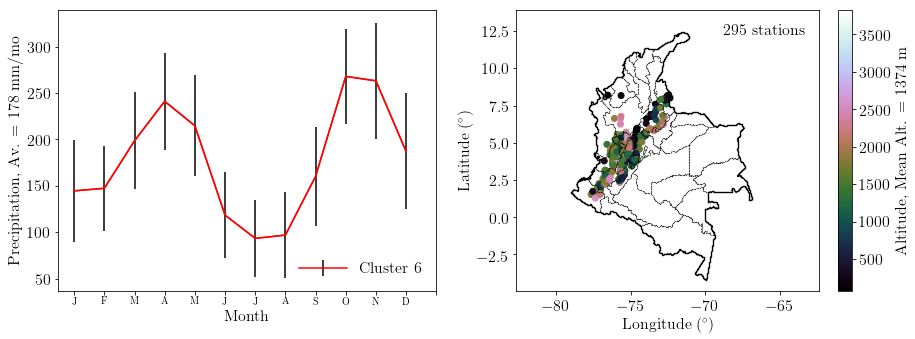

Number of stations in cluster 6 is 185


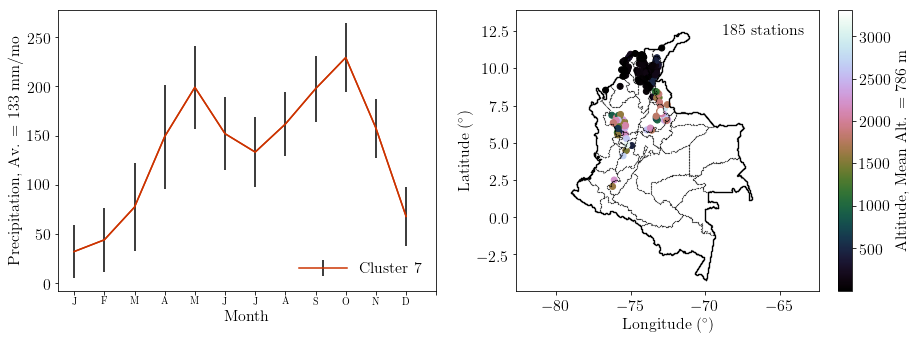

Number of stations in cluster 7 is 3


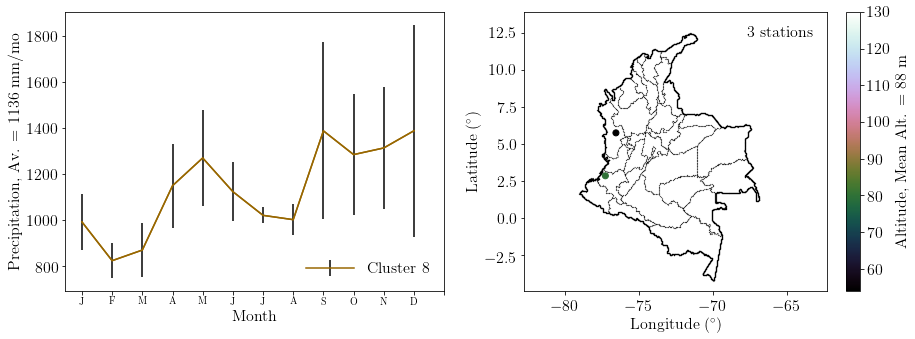

Number of stations in cluster 8 is 176


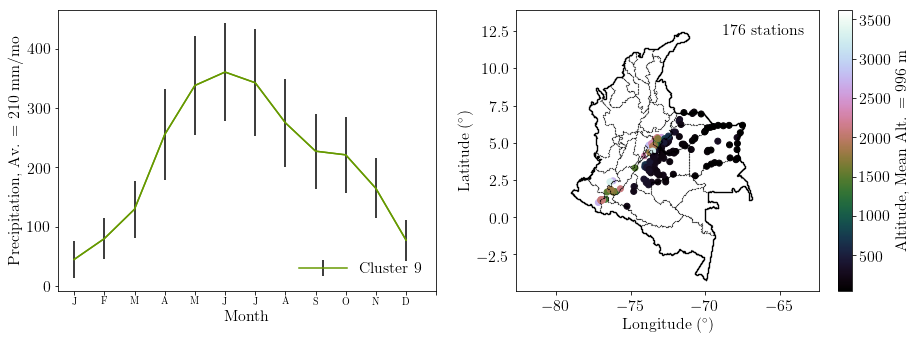

Number of stations in cluster 9 is 56


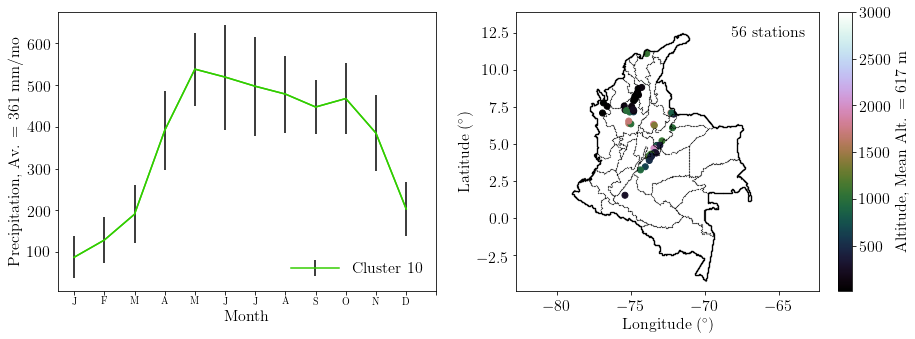

Number of stations in cluster 10 is 443


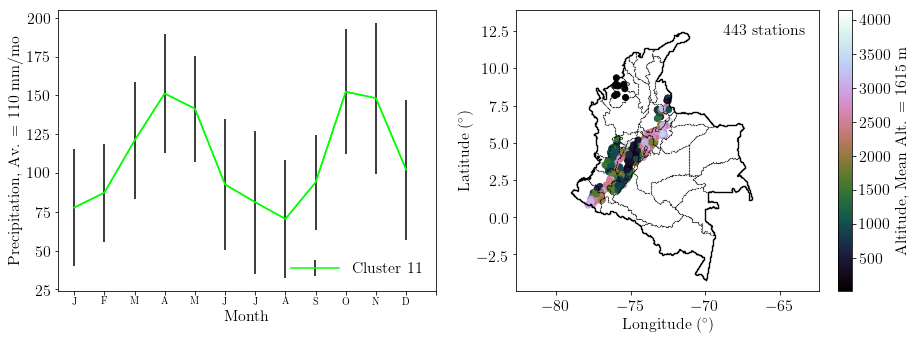

In [8]:
LATL,LONL,ALTL,CODL,cluster_labelL,latL,lonL,codeL,altL=data_reduction('lluvia.csv')

No. of stations that measure this variable =  2002 , No. of PCA components (95%) =  3
Explained variance ratio =  0.963298585519
Explained variance ratio per component =  [ 0.77041413  0.16628419  0.02660027]


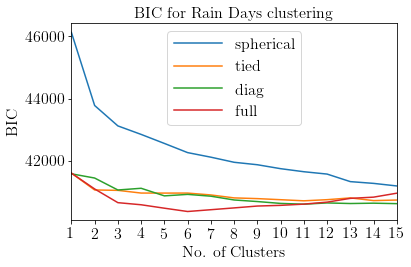

GMM covariance method: full , No. of GMM clusters =  6


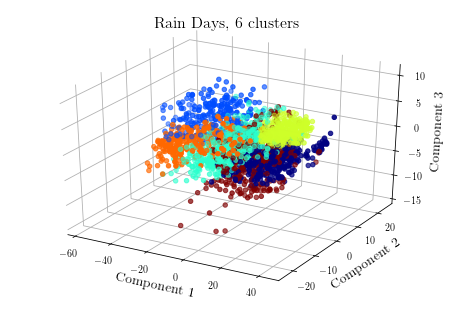

Number of stations in cluster 0 is 359


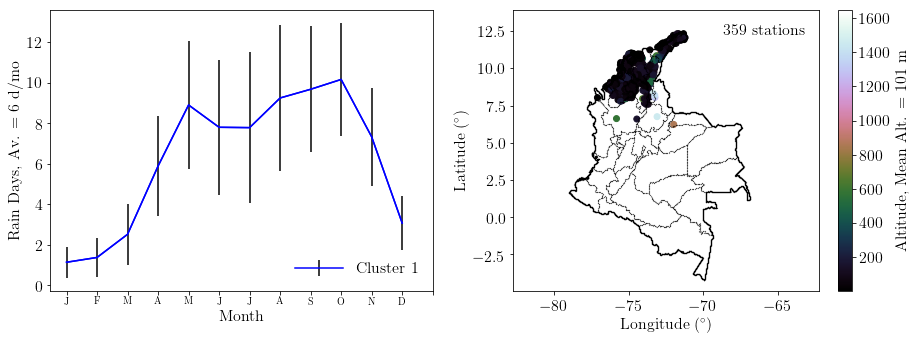

Number of stations in cluster 1 is 244


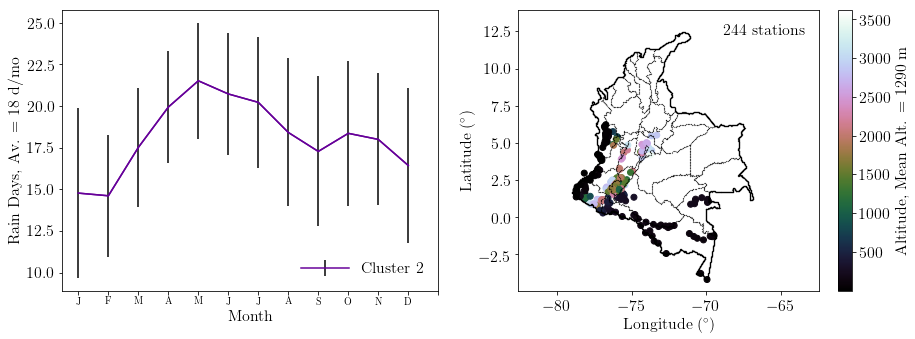

Number of stations in cluster 2 is 444


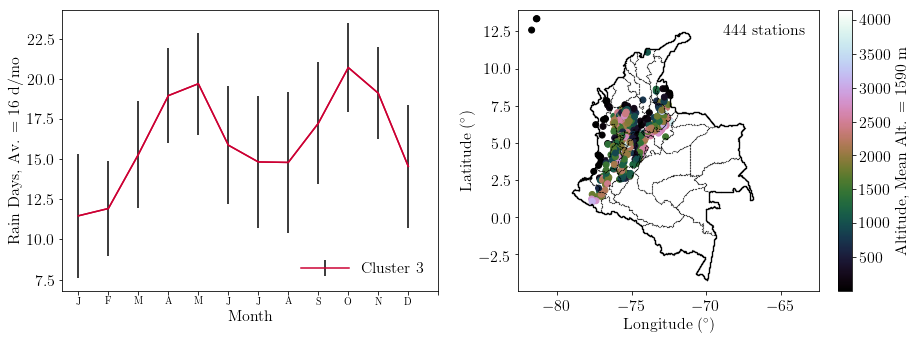

Number of stations in cluster 3 is 348


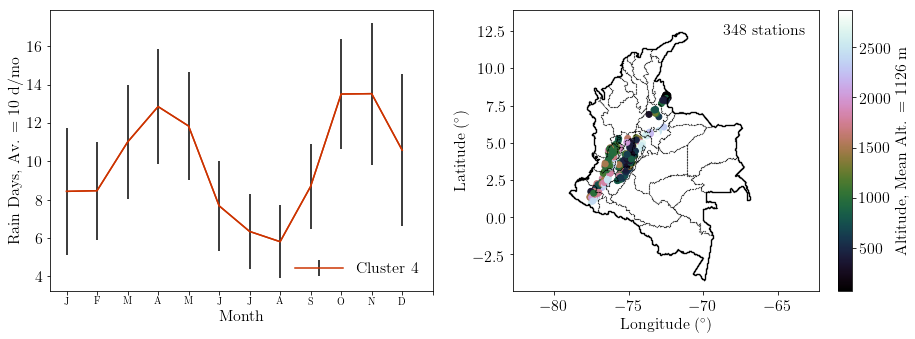

Number of stations in cluster 4 is 278


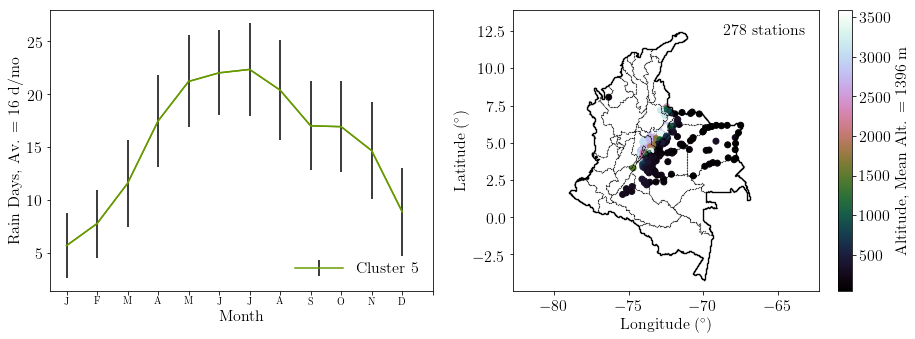

Number of stations in cluster 5 is 329


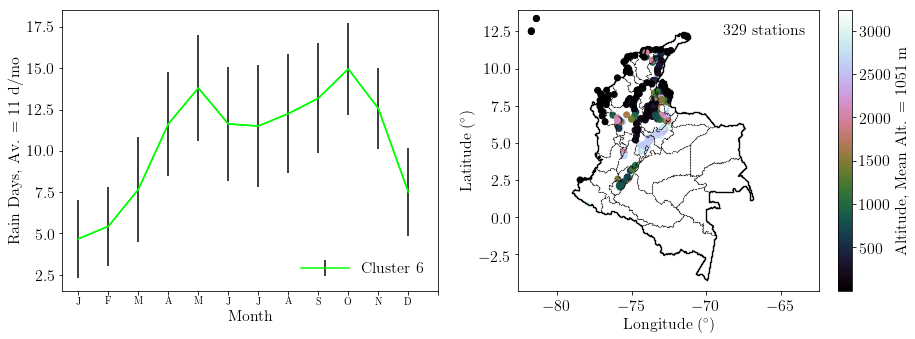

In [9]:
LATD,LOND,ALTD,CODD,cluster_labelD,latD,lonD,codeD,altD=data_reduction('diaslluvia.csv')

In [10]:
# Se unen todos los datos (los iniciales) de lonlat (hay repetidos)
CodT=np.hstack((codeB,codeH,codeL,codeD))
LonT=np.hstack((lonB,lonH,lonL,lonD))
LatT=np.hstack((latB,latH,latL,latD))
AltT=np.hstack((altB,altH,altL,altD))
np.savetxt('estaciones.txt',np.c_[CodT,LonT,LatT,AltT])
# después eliminamos repetidos y contamos cuantas variables mide cada estacion
proc = subprocess.Popen(["sort estaciones.txt | uniq -c > estaciones_medidas.txt"], stdout=subprocess.PIPE, shell=True)

In [11]:
proc = subprocess.Popen(["rm estaciones.txt"], stdout=subprocess.PIPE, shell=True)
proc = subprocess.Popen(["ls"], stdout=subprocess.PIPE, shell=True)
# 0=numero de variables medidas, 1=codigo de la estacion, 2,3=lonlat
EST=np.loadtxt('estaciones_medidas.txt')
stdout = proc.communicate()[0]
stdout.replace("\n"," ")

'AOD_PM25 bootstrap_snippets.ipynb brillo.csv candidates.csv colvecdep.txt diaslluvia.csv estaciones_medidas.txt fileList.txt humedad.csv LearningPyHDF.ipynb listcomp.txt lluvia.csv mnras ModeloAtmosferico.ipynb pasp PCA-IDEAM-WC.ipynb README.md slist.eps slistz.eps this.txt thos.txt yearlydata '

In [12]:
# funcion que une los grupos de interes para cada variable, segun la clasificacion del modelo de mixtura gaussiana
# genera un arreglo con los datos "extraidos", p.ej. de todos los datos de precipitacion saco solo los que me interesan
# PP es una lista con los grupos que me interesan para cada variable
def stitch(PP,ALT,LON,LAT,COD,altfilt):
    LN=np.array([])
    LT=np.array([])
    CD=np.array([])
    AT=np.array([])
    for i in PP:
        filter=ALT[:,i]>altfilt
        LN=np.hstack((LN,LON[:,i][(LON[:,i]!=0)*(filter)]))
        LT=np.hstack((LT,LAT[:,i][(LAT[:,i]!=0)*(filter)]))
        CD=np.hstack((CD,COD[:,i][(COD[:,i]!=0)*(filter)]))
        AT=np.hstack((AT,ALT[:,i][(ALT[:,i]!=0)*(filter)]))
    return np.vstack((CD,LN,LT,AT)).T

In [13]:
# Generamos otra lista con todas las estaciones que cumplen al menos un criterio
# Aqui usamos la funcion anterior, PP le indica a la funcion cuales grupos me interesan
altfilt=-1. # si es -1 es porque no estamos filtrando alturas todavia
PP=[0,3,4]
DATBT=stitch(PP,ALTB,LONB,LATB,CODB,altfilt)
PP=[1]
DATHT=stitch(PP,ALTH,LONH,LATH,CODH,altfilt)
PP=[1,4,6,10]
DATLT=stitch(PP,ALTL,LONL,LATL,CODL,altfilt)
PP=[0,3,5]
DATDT=stitch(PP,ALTD,LOND,LATD,CODD,altfilt)

In [14]:
df0=pd.read_csv('lluvia.csv')
df1=pd.read_csv('diaslluvia.csv')
df2=pd.read_csv('humedad.csv')
df3=pd.read_csv('brillo.csv')
tomadoscu=np.zeros((len(EST),3))      
tomadoscu[:,0]=np.in1d(EST[:,1],df1.CODIGO)*1
tomadoscu[:,1]=np.in1d(EST[:,1],df2.CODIGO)*1
tomadoscu[:,2]=np.in1d(EST[:,1],df3.CODIGO)*1
print "Stations with measured D, H, B: ", tomadoscu.sum(axis=0)
cumple=np.zeros((len(EST),4))
cumple[:,0]=np.in1d(EST[:,1],DATLT[:,0])*1
cumple[:,1]=np.in1d(EST[:,1],DATDT[:,0])*1
cumple[:,2]=np.in1d(EST[:,1],DATHT[:,0])*1
cumple[:,3]=np.in1d(EST[:,1],DATBT[:,0])*1
critfilter=(tomadoscu.sum(axis=1)+1-cumple.sum(axis=1))==0
critfilter.sum()

Stations with measured D, H, B:  [ 2002.   445.   336.]


665

# Análisis probabilístico

* $C$ es el evento "cumple los cuatro criterios", es decir pertenece a los clusters seleccionados de precipitación, días con lluvia, humedad y brillo solar. 

* $A$ es el evento "aparece en la lista", es decir "cada variable medida en la estación cumple nuestro criterio". 

* $T_i$ es el evento "la estación es del tipo $T_i$ con i entre 0 y 8", es decir el estado de medición de variables en esa estación es, por ejemplo $M_LM_DM_HM_B=1000=T_0$, donde $M_X=1/0$ significa "en esa estación se midió/no se midió la variable $X$". 

* $h$ es el evento "la estación está a la altura h"

La probabilidad de que una estación de cierto tipo cumpla los cuatro criterios y aparezca en la lista dado que está a una altura $h$ es,

$$P(C\cap A\cap T_i\ |\ h)=\frac{P(C\cap A\cap T_i\cap h)}{P(h)}$$ 

$$=\frac{P(h\ |\ C\cap A\cap T_i)}{P(h)}\ P(C\ |\ A\cap T_i)\ P(A\ |\ T_i)\ P(T_i)$$ 

* $P(h\ |\ C\cap A\cap T_i)$ es la distribución de alturas para cada estación que está en nuestra lista ($A$) y (se espera que) cumple nuestros cuatro criterios ($C$) dependiendo del tipo de estación ($T_i$).
* $P(C\ |\ A\cap T_i)$ es la probabilidad de que la estación cumpla los cuatro criterios ($C=L\cap D\cap H\cap B$) para  cada estación que está en nuestra lista ($A$) dependiendo de que una estación sea de cierto tipo ($T_i$).

$$P(C\ |\ A\cap T_i)=P(L\cap D\cap H\cap B\ |\ A\cap T_i)=\frac{P(L\cap D\cap H\cap B\cap A\cap T_i)}{P(A\cap T_i)}$$

Suponiendo que la estación es una tipo 1 (1100), ya sabemos que si la estación está en la lista y es de ese tipo ($A\cap T_1$), $L$ y $D$ se cumplen, por lo tanto,

$$P(C\ |\ A\cap T_1)=\frac{P(H\cap B\cap A\cap T_1)}{P(A\cap T_1)}=P(H\cap B\ |\ A\cap T_1)$$ 

Aproximaremos esa probabilidad (que en realidad es desconocida) como si fuera independiente del tipo de estación.

$$P(C\ |\ A\cap T_1)=P(H\cap B)$$

Por lo tanto esta probabilidad la calculamos según las variables que no haya medido la estación.

* $P(A\ |\ T_i)$ es la probabilidad de que una estación aparezca en la lista ($A$) dado el tipo de estación ($T_i$).
* $P(T_i)$ es la probabilidad de que una estación sea de cierto tipo ($T_i$).
* $P(h)$ es la probabilidad de que cualquier estación esté a una altura $h$.

Las estaciones se clasifican según la siguiente lista:

~~~~
 0=L    | 1000 
 1=LD   | 1100
 2=LH   | 1010
 3=LDH  | 1110
 4=LB   | 1001
 5=LDB  | 1101
 6=LBH  | 1011
 7=LDBH | 1111
 ~~~~
 ## Cálculo de $P(C\ |\ A\cap T_i)$

La probabilidad de que una estación cumpla con todos los criterios dado que aparece en la lista y es de cierto tipo (es decir, cumple con los que mide) es estimada de la siguiente forma:

* Para cada tipo de estación, miramos cuales variables no está midiendo (p. ej. una tipo 2 no mide D ni B).
* En la lista de todas las estaciones, miramos cuantas estaciones cumplen con los criterios de variables que no mide cada tipo de estación (p. ej. hay 97 estaciones que cumplen los criterios de D y B al tiempo). Esto significa que no asumimos que el cumplimiento de criterios por variable es independiente, sino que cada combinación de cumplimiento de criterios tiene una probabilidad.
* Dividimos sobre el número total de estaciones ($P$ = 97/2046 es la probabilidad de que ya habiendo cumplido con L y H, cumpla con D y B, basándonos en la información global, es decir qué tan fácil es cumplir D y B al tiempo respecto al número de estaciones).

In [15]:
# estimamos el tipo de estación según el número binario dado por D*2**0+H*2**1+B*2**2
# n=mide | tomados (DHB)
# 0=L    | 000 
# 1=LD   | 100
# 2=LH   | 010
# 3=LDH  | 110
# 4=LB   | 001
# 5=LDB  | 101
# 6=LBH  | 011
# 7=LDBH | 111
tipoest=np.zeros(len(EST[:,1]))
for k in range(3):
    tipoest+=tomadoscu[:,k]*(2.**k)
# numero de tipo de estaciones
numtipe=tipoest.max().astype(int)+1
medidas=tomadoscu.sum(axis=0)
pAlTi=np.zeros(numtipe)
pClAnTiP=np.zeros(numtipe)
pClAnTiN=np.zeros(numtipe)
pTiD=np.zeros(numtipe)
for k in range(numtipe):
    filter=(tipoest==k)
# probabilidad de que aparezca (A) dado el tipo de estación (Ti) -> P(A|Ti)
# medida como estaciones candidatas / estaciones de ese tipo
# de 29 estaciones tipo 1000 (T0) hay 13 que aparecen en nuestra lista (es decir, cumplen un criterio) -> P(A|T0)=13/29
# de 1563 estaciones tipo 1100 (T1) hay 579 que cumplen dos criterios -> P(A|T1)=579/1563
    pAlTi[k]=(cumple[filter].sum(axis=1)==tomadoscu[filter][0].sum()+1).sum()*1./filter.sum()
# probabilidad de que cumpla los cuatro criterios P(C|AnTi)
# estimada ingenuamente según posibilidades|tabla de probabilidad (1, 1/2, 1/4, 1/8)
    pClAnTiP[k]=1./2**np.abs(tomadoscu[filter]-1)[0].sum()   
# probabilidad de: si no midió las variables X, probabilidad de que cumpla los criterios X
# probabilidad calculada como si el cumplimiento de criterio por variable no fuera independiente
    ctemp=np.zeros(len(EST))
    myrange=np.arange(tomadoscu.shape[1])[np.abs(tomadoscu[filter]-1)[0]==1]
    for j in myrange:
        ctemp+=(cumple[:,j+1]==1)
    pClAnTiN[k]=(ctemp==len(myrange)).sum()*1./len(EST)
# probabilidad de tener el tipo de estación (dependiente) M es el estado de medir o no medir una variable
# contamos cuántas estaciones hay de ese tipo P(Ti)=P(MD n MH n MD)
    pTiD[k]=(filter).sum()*1./len(EST)

In [16]:
(pTiD*len(EST)).astype(int)

array([  29, 1563,    1,  117,    1,    8,   13,  314])

Mode:  1.0 , Mean:  5


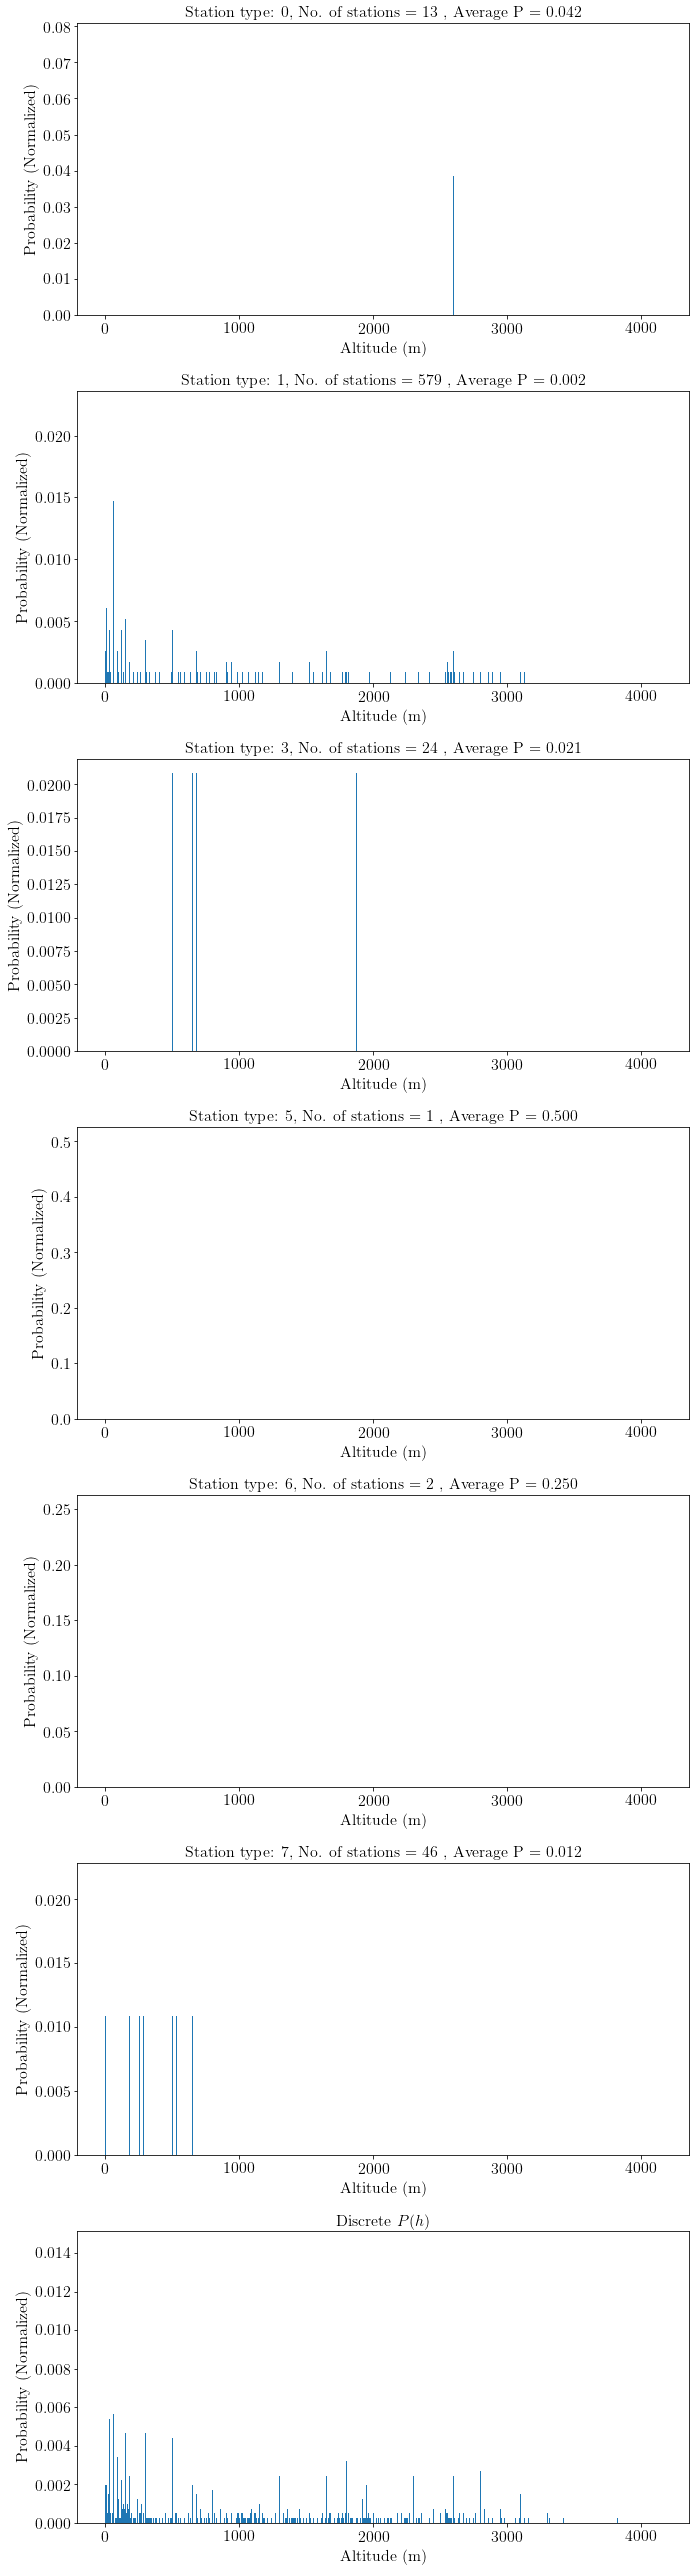

In [17]:
# Aquí estimamos la pdf discreta para las alturas -> P(h|CnAnTi) y P(h)
# No recomiendo hacerlo continuo (ni GMM ni KDE dan resultados satisfactorios)
# En caso dado puede ser mejor simplemente dejar bins de 1 metro, según la moda
altsfil=EST[:,4][EST[:,4]<4500]
hinter=np.unique(altsfil)[1:]-np.unique(altsfil)[:-1] # intervalo para histogramas (pdfs) de altura
m=stats.mode(hinter) # del promedio sacamos el ancho del bin para los pdfs
# la moda también se puede usar, el clustering final da un poco distinto
print "Mode: ", m[0][0], ", Mean: ",int(hinter.mean())
mybins=int(hinter.mean())
mybins=int((np.sort(EST[:,4])[1:]-np.sort(EST[:,4])[:-1]).mean())
altmax=EST[:,4].max().astype(int)
plt.figure(figsize=(10,36))
kk=0
paltmax=np.zeros(8)
proh=np.zeros((1+altmax/mybins,8))
for k in np.unique(tipoest[critfilter]).astype(int):
    kk+=1
    plt.subplot(len(np.unique(tipoest[critfilter]))+1, 1, kk)
    aux1,aux2,aux3=plt.hist(EST[critfilter][tipoest[critfilter]==k][:,4],bins=range(0,altmax+mybins+1,mybins),normed=True)
    proh[:,k]=aux1
    plt.title("Station type: %i, No. of stations = %s , Average P = %.3f" % (k,(tipoest[critfilter]==k).sum(),aux1[aux1!=0].mean()))
    paltmax[k]=aux1[aux1!=0].mean()
    plt.xlabel("Altitude (m)")
    plt.ylabel("Probability (Normalized)")
# Calculamos P(h) - discreto
plt.subplot(len(np.unique(tipoest[critfilter]))+1, 1, kk+1)
prohabs,b,c=plt.hist(EST[:,4],normed=True,bins=range(0,altmax+mybins+1,mybins))
plt.xlabel("Altitude (m)")
plt.ylabel("Probability (Normalized)")
plt.title(r"Discrete $P(h)$")
# Asignamos P(h) - discreto - a cada estación
palturaabs=np.zeros(len(EST))
for i in range(len(EST)):
        palturaabs[i]=prohabs[EST[i,4].astype(int)/mybins]

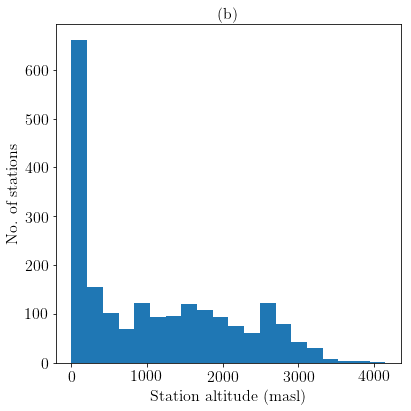

In [18]:
# this goes in the paper!
reso=300
plt.figure(figsize=(6,6))
ae,be,ce=plt.hist(EST[:,4],bins=20)
plt.xlabel("Station altitude (masl)")
plt.ylabel("No. of stations")
plt.title("(b)")
plt.savefig("pasp/elev.eps",dpi=reso)
plt.savefig("pasp/elev.pdf",dpi=reso)

In [19]:
# Calculamos P(h|CnAnTi) y P(CnAnTi) por distintos métodos
# P(Ti) se puede calcular contando estaciones (D, dependiente) = P(MLnMDnMHnMB) 
# o contando los MX por aparte (I, independiente) = P(ML)P(MD)P(MH)P(MB)
# P(C|AnTi) se puede estimar por tabla de probabilidad (P), o como es descrito arriba (N), con las variables no medidas
paltura=np.zeros(len(EST))
pCnAnTi2=np.zeros(len(EST))
pCnAnTi7=np.zeros(len(EST))
for i in range(len(EST)):
    if(EST[i,4]<4099): # Ponemos nuestro primer filtro de altura
        paltura[i]=proh[EST[i,4].astype(int)/mybins,tipoest[i].astype(int)]
    pCnAnTi2[i]=(pTiD*pAlTi*pClAnTiP)[tipoest[i].astype(int)]
    pCnAnTi7[i]=(pTiD*pAlTi*pClAnTiN)[tipoest[i].astype(int)]
# P(CnAnTi|h)
# 2 = pt-D pclanti-P (Tabla de probabilidad ingenua)
# 7 = pt-D pclanti-N ()
pro2=pCnAnTi2*paltura/palturaabs # no usar, solo sirve ilustrativamente
pro7=pCnAnTi7*paltura/palturaabs
probof=pro7

In [20]:
# Aquí obtenemos nuestra lista maestra y la expandemos
# 0 = tipo estación
# 1 = código
# 2,3 = lonlat
# 4 = altura
# 5 = probabilidad
listam=np.hstack((tipoest[:, np.newaxis],EST[:,1:],probof[:, np.newaxis]))[critfilter]
altmin=2000 # nuevo filtro de altura minima
altmax=3500 # nuevo filtro de altura maxima
listinf=listam[(listam[:,4]>=altmin)*(listam[:,4]<=altmax)]
listinf.shape

(121, 6)

In [21]:
# corte estricto para quitar estaciones muy lluviosas, humedas, o nubladas
filelist=['lluvia.csv','diaslluvia.csv','humedad.csv','brillo.csv']
limits=[130,17,100,30] # valores de corte
cutlistL=np.array([])
cutlistD=np.array([])
compds=len(listinf)
for f,limit in zip(filelist,limits):
    if f=='lluvia.csv':
        clul=cluster_labelL
        coden=codeL
        vname='Precipitation (mm)'
    if f=='diaslluvia.csv':
        clul=cluster_labelD
        coden=codeD
        vname='Rainy Days (dpm)'
    if f=='humedad.csv':
        clul=cluster_labelH
        coden=codeH
        vname='Relative Humidity (percent)'
    if f=='brillo.csv':
        clul=cluster_labelB
        coden=codeB
        vname='Sunshine (hpd)'
    kco=0
    df=pd.read_csv(f)
    for i in listinf[:,1]:
        pinl=listinf[listinf[:,1]==i][:,0]
        if (df.CODIGO==i).sum() > 0 :  
            datamonth=(df.as_matrix(columns=df.columns[8:20]))[np.argmax(df.CODIGO==i)]
            if (datamonth.mean()+datamonth.std())<limit:
                mylabel=r"%s %i$\pm$%.2f, $p$ = %i, cluster = %i" % (df.MUNICIPIO[df.CODIGO==i].iloc[0],datamonth.mean(),datamonth.std(),pinl,clul[coden==i][0])
                if f=='lluvia.csv':
                    cutlistL=np.append(cutlistL,i)
                if f=='diaslluvia.csv':
                    cutlistD=np.append(cutlistD,i)
            else:
                print "%s %s *%i* data is too high, p = %i" % (df.MUNICIPIO[df.CODIGO==i].iloc[0],vname,datamonth.mean()+datamonth.std(),pinl)
                if pinl > 600.:
                    print 'WARNING: GB %s got kicked out' % df.MUNICIPIO[df.CODIGO==i].iloc[0] 
        elif (df.CODIGO==i).sum()==0:
            kco+=1
            if f=='lluvia.csv':
                cutlistL=np.append(cutlistL,i)
            if f=='diaslluvia.csv':
                cutlistD=np.append(cutlistD,i)

Mutiscua Precipitation (mm) *147* data is too high, p = 1
Ibague Precipitation (mm) *160* data is too high, p = 0
Cajamarca Precipitation (mm) *138* data is too high, p = 1
Santa Isabel Precipitation (mm) *158* data is too high, p = 1
Murillo Precipitation (mm) *164* data is too high, p = 0
Rioblanco Precipitation (mm) *197* data is too high, p = 0
Roncesvalles Precipitation (mm) *180* data is too high, p = 1
Pauna Precipitation (mm) *150* data is too high, p = 1
Santa Sofia Precipitation (mm) *149* data is too high, p = 1
Cerrito Precipitation (mm) *137* data is too high, p = 1
Santa Barbara Precipitation (mm) *175* data is too high, p = 1
Covarachia Precipitation (mm) *163* data is too high, p = 1
Purace Precipitation (mm) *207* data is too high, p = 1
Silvia Precipitation (mm) *167* data is too high, p = 1
Totoro Precipitation (mm) *193* data is too high, p = 1
Toribio Precipitation (mm) *147* data is too high, p = 1
Pradera Precipitation (mm) *183* data is too high, p = 1
Palmira P

In [22]:
mkplots=False # poner true para ver comportamiento individual de las 83
if cutlistD.shape >= cutlistL.shape:
    shortlist=cutlistD[np.in1d(cutlistD,cutlistL)]
else:
    shortlist=cutlistL[np.in1d(cutlistL,cutlistD)]
slistcomp=listinf[np.in1d(listinf[:,1],shortlist)]
print "Shortlist size: ", slistcomp.shape[0]
cohlist=[]
coblist=[]
codlist=[]
finaldata=np.zeros((len(EST),18))
kind=0
compds=len(slistcomp)
clno=0 # hay que quitarlo
for f,limit in zip(filelist,limits):
    if f=='lluvia.csv':
        clul=cluster_labelL
        coden=codeL
        vtp=0.
        vname='Precipitation (mm)'
    if f=='diaslluvia.csv':
        clul=cluster_labelD
        coden=codeD
        vtp=1.
        vname='Rainy Days (dpm)'
    if f=='humedad.csv':
        clul=cluster_labelH
        vtp=2.
        coden=codeH
        vname='Relative Humidity (percent)'
    if f=='brillo.csv':
        clul=cluster_labelB
        vtp=3.
        coden=codeB
        vname='Sunshine (hpd)'
    kco=0
    df=pd.read_csv(f)
    if mkplots :
        plt.figure(figsize=(10,6))
        colors = iter(plt.cm.rainbow(np.linspace(0, 1, len(slistcomp[filter]))))
    for i in slistcomp[:,1]:
        pinl=slistcomp[slistcomp[:,1]==i][:,0]
        if (df.CODIGO==i).sum() > 0 :  
            datamonth=(df.as_matrix(columns=df.columns[8:20]))[np.argmax(df.CODIGO==i)]
            if (datamonth.mean()+datamonth.std())<limit:
                if mkplots :
                    mylabel=r"%s %.1f$\pm$%.2f, $p$ = %i, cluster = %i" % (df.MUNICIPIO[df.CODIGO==i].iloc[0],datamonth.mean(),datamonth.std(),pinl,clul[coden==i][0])
                    plt.plot(np.arange(12),datamonth,color=next(colors),label=mylabel)
                finaldata[kind]=np.hstack((np.array([i,vtp,pinl,clno,clul[coden==i][0],df.ELEV[df.CODIGO==i].iloc[0]]),datamonth))
                kind+=1
            else:
                print "%s %s *%i* data is too high, p = %i" % (df.MUNICIPIO[df.CODIGO==i].iloc[0],vname,datamonth.mean()+datamonth.std(),pinl)
                if pinl > 600.:
                    print 'GB %s got kicked out' % df.MUNICIPIO[df.CODIGO==i].iloc[0] 
        elif (df.CODIGO==i).sum()==0:
            kco+=1
#                print 'No %s data: %s, p = %i' % (vname,df0.MUNICIPIO[df0.CODIGO==i].iloc[0],pinl)
            if f[0]=='h':
                cohlist.append(i)
            if f[0]=='b':
                coblist.append(i)
            if f[0]=='d':
                codlist.append(i)
    if kco<compds:
        if mkplots :
            plt.title("%s at %i m" %(vname,slistcomp[:,4].mean()) )
            plt.legend()
            plt.show()
print "Shortlist size (sanity check): ",(np.unique(finaldata[:,0])!=0).sum()    

Shortlist size:  83
Shortlist size (sanity check):  83


In [23]:
# extrapolate to get more data for the shortlist from nearby stations
filelist=['lluvia.csv','diaslluvia.csv','humedad.csv','brillo.csv']
fdata=np.array([])
print "Data before extrapolation: ",finaldata[finaldata[:,0]!=0].shape[0]
for f in filelist[1:]:
    coun=0
    if f[0]=='d':
        colist=codlist
        vtp=1.
    if f[0]=='h':
        colist=cohlist
        vtp=2.
    if f[0]=='b':
        colist=coblist
        vtp=3.
    for i in colist:
        pinl=slistcomp[slistcomp[:,1]==i][:,0][0]
        mylat=conversion(df0.LATITUD[df0.CODIGO==i].iloc[0])
        mylon=conversion(df0.LONGITUD[df0.CODIGO==i].iloc[0])
        distarr=np.array([])
        for kki in range(len(EST)):
            distarr=np.append(distarr,np.sqrt((conversion(df0.LATITUD.iloc[kki])-mylat)**2+(conversion(df0.LONGITUD.iloc[kki])-mylon)**2))
        distarr[distarr==0]=100.
        for ki in np.asarray(df0.CODIGO[distarr*111.325 < 4.]):
            if f[0]=='d':
                df=df1
            if f[0]=='h':
                df=df2
            if f[0]=='b':
                df=df3
            if (df.CODIGO==ki).sum()>0:
                datamonth=(df.as_matrix(columns=df.columns[8:20]))[np.argmax(df.CODIGO==ki)]
                newline=np.hstack((np.array([i,vtp,pinl,-1.,-1.,df0.ELEV[df0.CODIGO==i].iloc[0]]),datamonth))
                if np.abs(df0.ELEV[df0.CODIGO==i].iloc[0]-df0.ELEV[df0.CODIGO==ki].iloc[0]) < 100. :
                    fdata=np.append(fdata,newline).reshape((len(fdata)+1,18))
                    coun+=1
    print "New data: ", f[:-4],coun   
print "Data after extrapolation: ", finaldata[finaldata[:,0]!=0].shape[0]+fdata.shape[0]

Data before extrapolation:  172
New data:  diaslluvia 0
New data:  humedad 15
New data:  brillo 12
Data after extrapolation:  199


In [24]:
# reduccion final de los datos
hlim=81.
excluh=fdata[fdata[:,1]==2][fdata[fdata[:,1]==2][:,6:].mean(axis=1)>hlim][:,0]
blim=4.
exclub=fdata[fdata[:,1]==3][fdata[fdata[:,1]==3][:,6:].mean(axis=1)<blim][:,0]
nfdata=fdata[np.logical_not(np.in1d(fdata[:,0],excluh))]
rnfdata=nfdata[np.logical_not(np.in1d(nfdata[:,0],exclub))]
frdata=finaldata[finaldata[:,0]!=0]
nfrdata=frdata[np.logical_not(np.in1d(frdata[:,0],excluh))]
rnfrdata=nfrdata[np.logical_not(np.in1d(nfrdata[:,0],exclub))]
final=np.vstack((rnfrdata,rnfdata))
finallist=np.unique(final[:,0])
filat=np.array([])
filon=np.array([])
proli=np.array([])
altli=np.array([])
estli=np.array([])
for i in finallist:
    filter=df0.CODIGO==i
    filat=np.append(filat,conversion(df0.LATITUD[filter].iloc[0]))
    filon=np.append(filon,conversion(df0.LONGITUD[filter].iloc[0]))
    altli=np.append(altli,df0.ELEV[filter].iloc[0])
    estli=np.append(estli,i)
    filter=slistcomp[:,1]==i
    proli=np.append(proli,1000*slistcomp[:,5][filter]/slistcomp[:,5].max())

In [25]:
filon.shape

(79,)

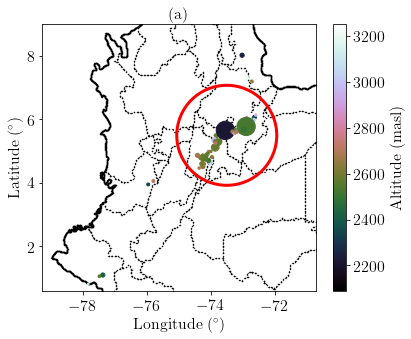

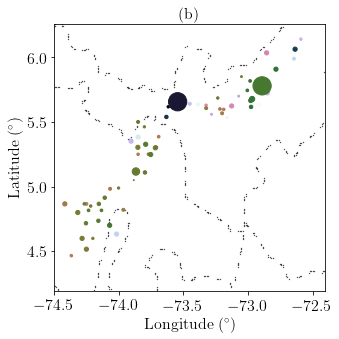

In [39]:
reso=300
plt.figure(figsize=(6,5))
plt.scatter(colvec[:,0],colvec[:,1],s=0.1,c='k')
#size=40
size=proli/3
plt.scatter(-filon,-filat,s=size,c=altli,cmap='cubehelix')
plt.colorbar(label='Altitude (masl)')
plt.scatter(-73.5,5.5,facecolors='none',s=10000, edgecolor='r', linewidth='3')
plt.axis('equal')
plt.axis([-78,-72,0.6,9])
plt.xlabel(r"Longitude ($^\circ$)")
plt.ylabel(r"Latitude ($^\circ$)")
plt.title("(a)")
plt.savefig("pasp/slist.eps",dpi=reso)
plt.savefig("pasp/slist.pdf",dpi=reso)
plt.show()
plt.figure(figsize=(5,5))
plt.scatter(colvec[:,0],colvec[:,1],s=0.1,c='k')
#size=40
size=proli/3
plt.scatter(-filon,-filat,s=size,c=altli,cmap='cubehelix')
plt.axis('equal')
plt.axis([-74.5,-72.4,4.45,6])
plt.xlabel(r"Longitude ($^\circ$)")
plt.ylabel(r"Latitude ($^\circ$)")
plt.title("(b)")
plt.savefig("pasp/slistz.eps",dpi=reso)
plt.savefig("pasp/slistz.pdf",dpi=reso)
plt.show()

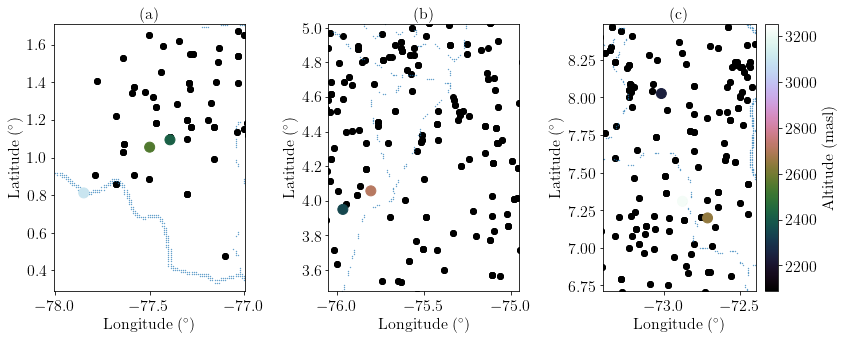

In [37]:
# outliers
plt.figure(figsize=(12,5))
plt.subplot(1, 3, 1)
plt.scatter(-LonT, -LatT,c='k')
plt.scatter(colvec[:,0],colvec[:,1],s=0.1)
size=10
size=proli/3
plt.scatter(-filon,-filat,s=100,c=altli,cmap='cubehelix')
#plt.colorbar()
plt.xlabel(r"Longitude ($^\circ$)")
plt.ylabel(r"Latitude ($^\circ$)")
plt.title("(a)")

plt.axis('equal')
plt.axis([-78,-77,0.5,1.5])

plt.subplot(1, 3, 2)

plt.scatter(-LonT, -LatT,c='k')
plt.scatter(colvec[:,0],colvec[:,1],s=0.1)
size=10
size=proli/3
plt.scatter(-filon,-filat,s=100,c=altli,cmap='cubehelix')
plt.xlabel(r"Longitude ($^\circ$)")
plt.ylabel(r"Latitude ($^\circ$)")
plt.title("(b)")
#plt.colorbar()

plt.axis('equal')
plt.axis([-76,-75,3.5,5])

plt.subplot(1, 3, 3)
plt.scatter(-LonT, -LatT,c='k')
plt.scatter(colvec[:,0],colvec[:,1],s=0.1)
size=10
size=proli/3
plt.scatter(-filon,-filat,s=100,c=altli,cmap='cubehelix')
plt.colorbar(label='Altitude (masl)')
plt.xlabel(r"Longitude ($^\circ$)")
plt.ylabel(r"Latitude ($^\circ$)")
plt.title("(c)")
plt.axis('equal')
plt.axis([-73.4,-72.4,7.1,8.1])
plt.savefig("pasp/outliers.eps",dpi=reso)
plt.savefig("pasp/outliers.pdf",dpi=reso)

In [28]:
bfilter=(4.3<-filat)&(-filat<6.2)&(filon<74.5)&(72.4<filon)
unifd=(np.vstack((filat,filon,altli)).T)[bfilter]
prolin=proli[bfilter]
festli=estli[bfilter]
altlin=altli[bfilter]

GMM covariance method: spherical , No. of GMM clusters =  6


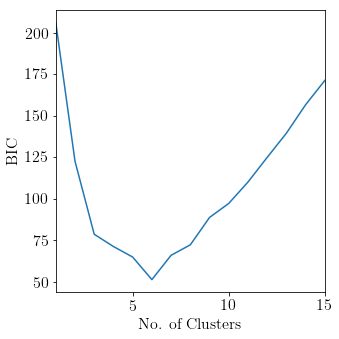

In [29]:
plt.figure(figsize=(5,5))
cv_types = ['spherical']
Xbic=unifd[:,0:2]
compo=15
thn=len(cv_types)
BIC=np.zeros((compo+1,thn))
kik=0
for cv_type in cv_types:
    for kcomp in np.arange(compo)+1:        
        gmm = GMM(kcomp, covariance_type=cv_type, random_state=0)
        gmm.fit(Xbic)
        BIC[kcomp,kik]=gmm.bic(Xbic)
        bicold=gmm.bic(Xbic)
    kik+=1    
compx=np.arange(compo+1)[1:]
BIC=BIC[1:]
for i, cv_type in zip(range(thn),cv_types):
    plt.plot(compx,BIC[:,i],label=cv_type)
plt.xlim(1,compo)
plt.xlabel("No. of Clusters")
plt.ylabel("BIC")
minperm=np.argmin(BIC,axis=0)
bicsmin=np.array([])
for i in range(len(minperm)):
    bicsmin=np.append(bicsmin,BIC[minperm[i],i])
covt=cv_types[np.argmin(bicsmin)]
kcomp=minperm[np.argmin(bicsmin)]+1
print "GMM covariance method:", covt, ", No. of GMM clusters = ", kcomp
gmm = GMM(kcomp, covariance_type=covt, random_state=0)
r=gmm.fit(Xbic)
cluster_label_geo = gmm.predict(Xbic)
#plt.savefig("pasp/geobic.eps",dpi=reso)
#plt.savefig("pasp/geobic.pdf",dpi=reso)

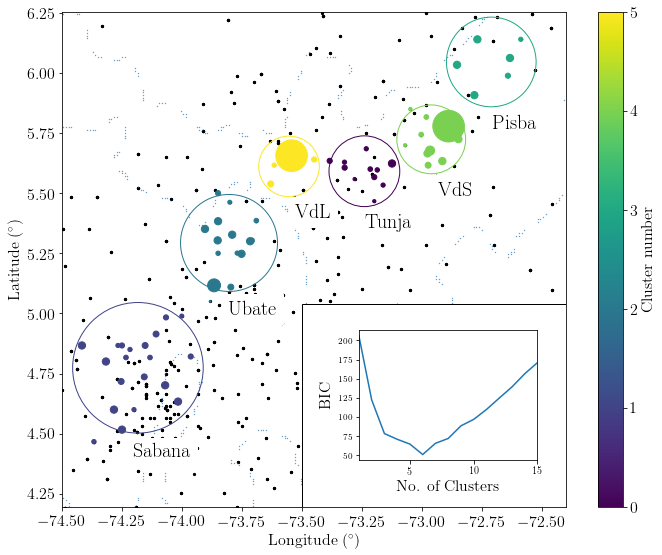

In [35]:

def add_subplot_axes(ax,rect,axisbg='w'):
    fig = plt.gcf()
    box = ax.get_position()
    width = box.width
    height = box.height
    inax_position  = ax.transAxes.transform(rect[0:2])
    transFigure = fig.transFigure.inverted()
    infig_position = transFigure.transform(inax_position)   
    x = infig_position[0]
    y = infig_position[1]
    width *= rect[2]
    height *= rect[3]  # <= Typo was here
    subax = fig.add_axes([x,y,width,height],axisbg=axisbg)
    x_labelsize = subax.get_xticklabels()[0].get_size()
    y_labelsize = subax.get_yticklabels()[0].get_size()
    x_labelsize *= rect[2]**0.5
    y_labelsize *= rect[3]**0.5
    subax.xaxis.set_tick_params(labelsize=x_labelsize)
    subax.yaxis.set_tick_params(labelsize=y_labelsize)

    return subax

colors = iter(plt.cm.viridis(np.linspace(0, 1, len(r.covars_))))
list=[]
for i in range(6):
    list=list+[(next(colors))]

def example2(list):
    fig = plt.figure(figsize=(10,8))
    axes = []
    subpos = [0.625,0.075,0.4,0.3]
    mytext=['Tunja','Sabana','Ubate','Pisba','VdS','VdL']
    x = np.linspace(-np.pi,np.pi)
    for i in np.arange(1)+1:
        axes.append(fig.add_subplot(1,1,1))
    for axis in axes:
        axis.scatter(-LonT, -LatT,c='k',s=5)
        axis.scatter(colvec[:,0],colvec[:,1],s=0.1)
        size=proli[bfilter]
        axis.scatter(-r.means_[:,1],-r.means_[:,0],s=r.covars_[:,0]*9e5,facecolors='none', edgecolor=list, linewidth='1')
        this=axis.scatter(-unifd[:,1],-unifd[:,0],s=size,c=cluster_label_geo)
        fig.colorbar(this,label='Cluster number')
        axis.set_xlabel(r"Longitude ($^\circ$)")
        axis.set_ylabel(r"Latitude ($^\circ$)")
        axis.axis('equal')
        axis.axis([-74.5,-72.4,4.45,6])
        for kkk in range(len(r.means_)):
            point=np.sqrt(r.covars_[:,0])
            axis.text(-r.means_[:,1][kkk]+0.1,(-r.means_[:,0]-2.2*point-0.05)[kkk], mytext[kkk], size=20,color='k',
         ha="center", va="center",bbox=dict(boxstyle="square",ec='w',fc='w',))
        subax1 = add_subplot_axes(axis,subpos)     
        subax1.plot(compx,BIC[:,0],label=cv_type)
        subax1.set_xlim(1,compo)
        subax1.set_xlabel("No. of Clusters")
        subax1.set_ylabel("BIC")
        axis.add_patch(patches.Rectangle((-73.5, 4.19), 1.1, 0.85,facecolor="white",edgecolor='k',linewidth='1'))
#        axis.add_patch(patches.Rectangle((-73.74, 4.25), 0.2, 0.7,facecolor="white"))

example2(list)
plt.savefig("pasp/unif.eps",dpi=reso)
plt.savefig("pasp/unif.pdf",dpi=reso)
plt.show()


In [32]:
list

[array([ 0.267004,  0.004874,  0.329415,  1.      ]),
 array([ 0.253935,  0.265254,  0.529983,  1.      ]),
 array([ 0.163625,  0.471133,  0.558148,  1.      ]),
 array([ 0.134692,  0.658636,  0.517649,  1.      ]),
 array([ 0.477504,  0.821444,  0.318195,  1.      ]),
 array([ 0.993248,  0.906157,  0.143936,  1.      ])]

In [296]:
degtokm=111.25
np.vstack((r.means_.T,np.pi*r.covars_[:,0]*(degtokm)**2,degtokm*np.sqrt(r.covars_[:,0]))).T[np.argsort(r.means_[:,0])]

array([[  -6.04550721,   72.71302498,  347.31918654,   10.51452   ],
       [  -5.72373178,   72.96280331,  204.5213942 ,    8.06853033],
       [  -5.6111811 ,   73.55472109,  158.82975808,    7.11035036],
       [  -5.59115096,   73.2410971 ,  216.39005164,    8.29934291],
       [  -5.29291106,   73.80440538,  406.4231033 ,   11.37402707],
       [  -4.77383713,   74.1835444 ,  736.68117593,   15.31316105]])

In [ ]:
ixmin=np.log(np.unique(listinf[:,5])).min()
ixmax=np.log(np.unique(listinf[:,5])).max()
mulx=9/(ixmax-ixmin)
addx=1-ixmin*mulx
ifc=0
acou=0
for ifc in np.unique(cluster_label_geo):
    mfilter=cluster_label_geo==ifc
    latc=r.means_[ifc,0]
    lonc=r.means_[ifc,1]
    databycl=np.zeros(((mfilter.sum()),9))
    maxpco=festli[mfilter][np.argmax(prolin[mfilter])]
    ibfilter=prolin[mfilter]==prolin[mfilter].max()
    if ibfilter.sum() > 1:
        maxpco=festli[mfilter][ibfilter][np.argmax(altlin[mfilter][ibfilter])]
    names=np.array([])
    munis=np.array([])
    filt1=df0.CODIGO==maxpco
    kli=0
    for i,j,k in zip(festli[mfilter],prolin[mfilter],altlin[mfilter]):
        filt2=df0.CODIGO==i
        dist=degtokm*np.sqrt((conversion(df0.LATITUD[filt1].iloc[0])-conversion(df0.LATITUD[filt2].iloc[0]))**2+(conversion(df0.LONGITUD[filt1].iloc[0])-conversion(df0.LONGITUD[filt2].iloc[0]))**2)
        distc=degtokm*np.sqrt((latc-conversion(df0.LATITUD[filt2].iloc[0]))**2+(lonc-conversion(df0.LONGITUD[filt2].iloc[0]))**2)
        databycl[kli]=np.array([int(i),int(dist),int(distc),int(j),int((df0.as_matrix(columns=df0.columns[8:20]))[np.argmax(df0.CODIGO==i)].mean()),int((df1.CODIGO==i).sum()*(df1.as_matrix(columns=df1.columns[8:20]))[np.argmax(df1.CODIGO==i)].mean()),int((df2.CODIGO==i).sum()*(df2.as_matrix(columns=df2.columns[8:20]))[np.argmax(df2.CODIGO==i)].mean()),int((df3.CODIGO==i).sum()*(df3.as_matrix(columns=df3.columns[8:20]))[np.argmax(df3.CODIGO==i)].mean()),int(k)])
        names=np.append(names,df0.NOMBRE[df0.CODIGO==i].iloc[0])
        munis=np.append(munis,df0.MUNICIPIO[df0.CODIGO==i].iloc[0])
        kli+=1
    dfbycl=pd.DataFrame(data=databycl[databycl[:,1].argsort()][:,:],columns=['code','dist','distc','prob','lmean','dmean','hmean','bmean','alt'])
    dfbycl['name']=names[databycl[:,1].argsort()]
    dfbycl['muni']=munis[databycl[:,1].argsort()]
    dfbycl['qind']=np.around(np.log(dfbycl.prob)*mulx+addx,1)
    dfbycl['clno']=ifc
    if acou==0:
        dftot=dfbycl
    if acou > 0:
        dftot=dftot.append(dfbycl, ignore_index=True)
    acou+=1    

In [33]:
dftot=dftot.sort('code')

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


In [34]:
ftotprob=probof[np.in1d(EST[:,1],dftot.code)]
ixmin=np.log(np.unique(probof[critfilter])).min()
ixmax=np.log(np.unique(probof[critfilter])).max()
mulx=9/(ixmax-ixmin)
addx=1-ixmin*mulx
dftot['newq']=np.around(np.log(ftotprob)*mulx+addx,1)

In [44]:
dftot[dftot.clno==0]

code  dist  distc  prob  lmean  dmean  hmean  bmean     alt  \
10  24010840.0  28.0   16.0  26.0   66.0    8.0    0.0    0.0  3195.0   
8   24030310.0  22.0   10.0  17.0   74.0   11.0    0.0    0.0  2820.0   
9   24030450.0  22.0    9.0  26.0   61.0   10.0    0.0    0.0  2645.0   
6   24030500.0  18.0    5.0  10.0   44.0    9.0    0.0    0.0  2900.0   
5   24030530.0  13.0   10.0  17.0   71.0   10.0    0.0    0.0  2580.0   
2   24030550.0  10.0    5.0  26.0   53.0    8.0    0.0    0.0  2675.0   
0   24030770.0   0.0   13.0  53.0   55.0    8.0    0.0    0.0  2836.0   
3   24030780.0  10.0    2.0  21.0   55.0    7.0    0.0    0.0  2690.0   
4   24030800.0  10.0   10.0  17.0   64.0   10.0    0.0    0.0  3200.0   
7   24035190.0  19.0   14.0  10.0   71.0    0.0    0.0    0.0  3250.0   
1   24035300.0   7.0    5.0  19.0   60.0   12.0    0.0    0.0  2700.0   

               name       muni  qind  clno  newq  
10          Panelas   Motavita  14.9     0   5.2  
8           Combita    Combita  14.3     0   4.7  
9        Encanto El     Oicata  14.9     0   5.2  
6   Col Dptal Agrop    Chivata  13.5     0   4.0  
5       San Antonio       Tuta  14.3     0   4.7  
2         San Pedro       Toca  14.9     0   5.2  
0       Garrocho El       Toca  16.0     0   6.1  
3          Hotel El       Toca  14.6     0   4.9  
4     Casa Amarilla       Toca  14.3     0   4.7  
7          San Jose  Siachoque  13.5     0   4.0  
1     San Cristobal       Toca  14.5     0   4.8

In [45]:
dftot[dftot.clno==1]

code  dist  distc  prob  lmean  dmean  hmean  bmean     alt  \
19  21200510.0  29.0   29.0  53.0   52.0   12.0    0.0    0.0  2618.0   
24  21200550.0  36.0   12.0  26.0   81.0    7.0    0.0    0.0  2725.0   
26  21200690.0  38.0   15.0  53.0   89.0    9.0    0.0    0.0  2610.0   
25  21201070.0  38.0   13.0  17.0   70.0    9.0    0.0    0.0  2580.0   
11  21201120.0   0.0   24.0  53.0   81.0   11.0    0.0    0.0  3045.0   
20  21201210.0  30.0   10.0  35.0   62.0   12.0    0.0    0.0  2575.0   
12  21201230.0   9.0   14.0  53.0   74.0   10.0    0.0    0.0  2520.0   
21  21201270.0  31.0    7.0  21.0   70.0   12.0    0.0    0.0  2550.0   
16  21201360.0  24.0    7.0  21.0   64.0    7.0    0.0    0.0  2550.0   
14  21201540.0  20.0   19.0  17.0   50.0   13.0    0.0    0.0  2640.0   
18  21201660.0  29.0   22.0  53.0   44.0    9.0    0.0    0.0  2607.0   
27  21201760.0  39.0   26.0  26.0   35.0    5.0    0.0    0.0  2680.0   
22  21205570.0  32.0    9.0  18.0   69.0   13.0    0.0    4.0  2590.0   
28  21205910.0  39.0   31.0  15.0   60.0   12.0    0.0    0.0  2600.0   
15  21205920.0  21.0   24.0  26.0   70.0   12.0    0.0    0.0  2650.0   
23  21206020.0  32.0   17.0  35.0   69.0   11.0    0.0    0.0  2575.0   
17  21206060.0  27.0   10.0  35.0   39.0    9.0    0.0    0.0  2575.0   
13  21206210.0  19.0    5.0  35.0   61.0   12.0    0.0    0.0  2560.0   
30  21206290.0  51.0   27.0  53.0   73.0   12.0    0.0    0.0  2673.0   
29  21206340.0  43.0   39.0  19.0   51.0   12.0    0.0    0.0  2700.0   

                  name        muni  qind  clno  newq  
19   Sibate Apostolica      Sibate  16.0     1   6.1  
24   Union La-El Rosal  Subachoque  14.9     1   5.2  
26   Tesoro-Vertientes  Facatativa  16.0     1   6.1  
25          Corazon El  Facatativa  14.3     1   4.7  
11           Casita La   La Calera  16.0     1   6.1  
20             Hato El       Tenjo  15.4     1   5.6  
12    Enmanuel D Alzon   Bogota DC  16.0     1   6.1  
21            Tibar El      Madrid  14.6     1   4.9  
16            Sta Ines       Tenjo  14.6     1   4.9  
14                Bosa   Bogota DC  14.3     1   4.7  
18                Fute      Soacha  16.0     1   6.1  
27          Sta Isabel       Tabio  14.9     1   5.2  
22        Primavera La  Subachoque  14.4     1   4.7  
28          Cosecha La   Zipaquira  14.1     1   4.6  
15            Suasuque        Sopo  14.9     1   5.2  
23          Santillana       Tabio  15.4     1   5.6  
17          Casablanca      Madrid  15.4     1   5.6  
13  Flores Colombianas       Funza  15.4     1   5.6  
30             Venecia  Facatativa  16.0     1   6.1  
29     Paraiso Perdido      Sibate  14.5     1   4.8

In [46]:
dftot[dftot.clno==2]

code  dist  distc   prob  lmean  dmean  hmean  bmean     alt  \
32  21201410.0   7.0   28.0    2.0   66.0    0.0    0.0    0.0  2600.0   
33  21201620.0   7.0   20.0   35.0   59.0   10.0    0.0    0.0  2575.0   
31  21205400.0   0.0   20.0  166.0   52.0   10.0   77.0    4.0  2580.0   
41  24010070.0  27.0   10.0   26.0   63.0   12.0    0.0    0.0  2650.0   
35  24010140.0  18.0    6.0   17.0   57.0    9.0    0.0    0.0  2620.0   
43  24010170.0  35.0   16.0   21.0   73.0   10.0    0.0    0.0  2690.0   
39  24010280.0  26.0    9.0   53.0   57.0   10.0    0.0    0.0  2585.0   
42  24010440.0  29.0   11.0   53.0   60.0    8.0    0.0    0.0  3130.0   
40  24010610.0  26.0   12.0   53.0   54.0   12.0    0.0    0.0  2970.0   
44  24011060.0  39.0   18.0   15.0   83.0   12.0    0.0    0.0  2600.0   
36  24011080.0  19.0    7.0   53.0   51.0    5.0    0.0    0.0  2562.0   
38  24011090.0  24.0    4.0   53.0   62.0   13.0    0.0    0.0  2555.0   
37  24015110.0  20.0    5.0   53.0   62.0   12.0    0.0    0.0  2610.0   
45  24015130.0  42.0   23.0   26.0   67.0   11.0    0.0    0.0  2572.0   
34  24015210.0  14.0    6.0   19.0   57.0   10.0    0.0    0.0  2700.0   

                  name                         muni  qind  clno  newq  
32              Acandy                      Nemocon  11.1     2   2.2  
33              Suesca                       Suesca  15.4     2   5.6  
31      Checua-Nemocon                      Nemocon  17.7     2   7.6  
41             Leticia                  Lenguazaque  14.9     2   5.2  
35            Cucunuba                     Cucunuba  14.3     2   4.7  
43            Guacheta                     Guacheta  14.6     2   4.9  
39              Tapias                  Lenguazaque  16.0     2   6.1  
42       Tres Esquinas                         Susa  16.0     2   6.1  
40    Carmen de Carupa             Carmen de Carupa  16.0     2   6.1  
44                Susa                         Susa  14.1     2   4.6  
36          Cucunuba 1                     Cucunuba  16.0     2   6.1  
38           Ubate Gja  Villa de San Diego de Ubate  16.0     2   6.1  
37  Boyera La Automati  Villa de San Diego de Ubate  16.0     2   6.1  
45            Simijaca                     Simijaca  14.9     2   5.2  
34           Sutatausa                    Sutatausa  14.5     2   4.8

In [47]:
dftot[dftot.clno==3]

code  dist  distc  prob  lmean  dmean  hmean  bmean     alt  \
51  24030160.0  25.0   17.0  53.0   60.0   10.0    0.0    0.0  2486.0   
48  24030570.0  17.0    8.0  53.0   61.0    7.0    0.0    0.0  2328.0   
49  24030580.0  20.0   17.0  17.0   77.0    8.0    0.0    0.0  2962.0   
47  24030650.0  15.0   15.0  53.0   88.0   10.0    0.0    0.0  2833.0   
46  24030670.0   0.0   12.0  53.0   88.0   11.0    0.0    0.0  3240.0   
50  24030690.0  21.0    9.0  26.0   74.0   11.0    0.0    0.0  3052.0   

          name         muni  qind  clno  newq  
51       Tasco        Tasco  16.0     3   6.1  
48   Aposentos       Socota  16.0     3   6.1  
49      Jerico       Jerico  14.3     3   4.7  
47      Tutasa       Tutaza  16.0     3   6.1  
46  Sta Rosita  Sativanorte  16.0     3   6.1  
50     Curital        Socha  14.9     3   5.2

In [48]:
dftot[dftot.clno==4]

code  dist  distc    prob  lmean  dmean  hmean  bmean     alt  \
55  24030190.0   7.0   12.0    53.0   65.0    9.0    0.0    0.0  2970.0   
63  24030230.0  20.0   12.0    35.0   52.0    9.0    0.0    0.0  2470.0   
57  24030410.0  13.0    5.0    22.0   62.0    7.0    0.0    0.0  2500.0   
64  24030510.0  22.0   12.0    10.0   74.0    9.0    0.0    0.0  2900.0   
60  24030540.0  15.0    6.0    53.0   57.0    9.0    0.0    0.0  2486.0   
62  24030610.0  19.0   17.0    10.0   69.0   10.0    0.0    0.0  2590.0   
61  24030760.0  16.0   11.0    53.0   65.0   10.0    0.0    0.0  3225.0   
54  24030790.0   5.0    6.0    22.0   66.0   10.0    0.0    0.0  2500.0   
53  24030940.0   3.0    7.0    22.0   60.0   12.0    0.0    0.0  2500.0   
56  24031040.0  11.0   10.0    22.0   70.0    9.0    0.0    0.0  2500.0   
58  24035140.0  13.0    4.0    22.0   59.0   10.0    0.0    0.0  2500.0   
52  24035150.0   0.0   10.0  1000.0   68.0   13.0   74.0    4.0  2530.0   
59  24035340.0  14.0    5.0    83.0   61.0   12.0   75.0    5.0  2500.0   

                  name                   muni  qind  clno  newq  
55              Mongui                 Mongui  16.0     4   6.1  
63                 Iza                    Iza  15.4     4   5.6  
57            Tibasosa               Tibasosa  14.7     4   5.0  
64           Cerezo El                  Paipa  13.5     4   4.0  
60          Firavitoba             Firavitoba  16.0     4   6.1  
62         Empoduitama                Duitama  13.5     4   4.0  
61  Crucero El Villita               Sogamoso  16.0     4   6.1  
54               Nobsa                  Nobsa  14.7     4   5.0  
53                Sena               Sogamoso  14.7     4   5.0  
56        Creciente La  Santa Rosa de Viterbo  14.7     4   5.0  
58         Venecia Hda               Sogamoso  14.7     4   5.0  
52           Belencito                  Nobsa  20.5     4  10.0  
59     Apto A Lleras C               Sogamoso  16.7     4   6.7

In [49]:
dftot[dftot.clno==5]

code  dist  distc    prob  lmean  dmean  hmean  bmean     alt  \
69  24010180.0  16.0   11.0    35.0   81.0    8.0    0.0    0.0  2290.0   
67  24010290.0   9.0    6.0    17.0   64.0    7.0    0.0    0.0  2090.0   
66  24010410.0   6.0    1.0    10.0   55.0    7.0    0.0    0.0  2120.0   
68  24010830.0  10.0   12.0    26.0   73.0   12.0    0.0    0.0  2985.0   
65  24015300.0   0.0    5.0  1000.0   83.0   12.0   75.0    4.0  2215.0   

                 name            muni  qind  clno  newq  
69            Raquira         Raquira  15.4     5   5.6  
67        Sutamarchan     Sutamarchan  14.3     5   4.7  
66     Emporio El Hda  Villa de Leyva  13.5     5   4.0  
68  San Pedro Iguaque        Chiquiza  14.9     5   5.2  
65     Villa de Leiva  Villa de Leyva  20.5     5  10.0

In [61]:
dftot.newq.min()

2.2000000000000002

In [474]:
dftot.to_csv("candidates.csv")

In [321]:
mycols=[ 'Cluster Number','Station Name','Quality Index','Distance to Cluster Center','Mean Precipitation (mm/mo)','Mean Rain Days (d/mo)','Mean Relative Humidity (%)','Mean Sunshine Duration (h/d)','Altitude']
thi=dftot[[ 'clno','muni','newq','distc','lmean','dmean','hmean','bmean','alt']].sort_values(by='clno')
thi.columns=mycols

In [436]:
print thi[(af.clno==2)|(af.clno==4)].to_latex(index=False)

\begin{tabular}{rlrrrrrrr}
\toprule
 Cluster Number &                 Station Name &  Quality Index &  Distance to Cluster Center &  Mean Precipitation (mm/mo) &  Mean Rain Days (d/mo) &  Mean Relative Humidity (\%) &  Mean Sunshine Duration (h/d) &  Altitude \\
\midrule
              2 &                    Sutatausa &            4.8 &                         6.0 &                        57.0 &                   10.0 &                         0.0 &                           0.0 &    2700.0 \\
              2 &                     Simijaca &            5.2 &                        23.0 &                        67.0 &                   11.0 &                         0.0 &                           0.0 &    2572.0 \\
              2 &  Villa de San Diego de Ubate &            6.1 &                         5.0 &                        62.0 &                   12.0 &                         0.0 &                           0.0 &    2610.0 \\
              2 &  Villa de San Diego de Ubate &  

In [ ]:
cat this.txt | sort -t "&" -k1,1n -k3,3n >thos.txt # en bash para organizar el print .to_latex (pura pereza)

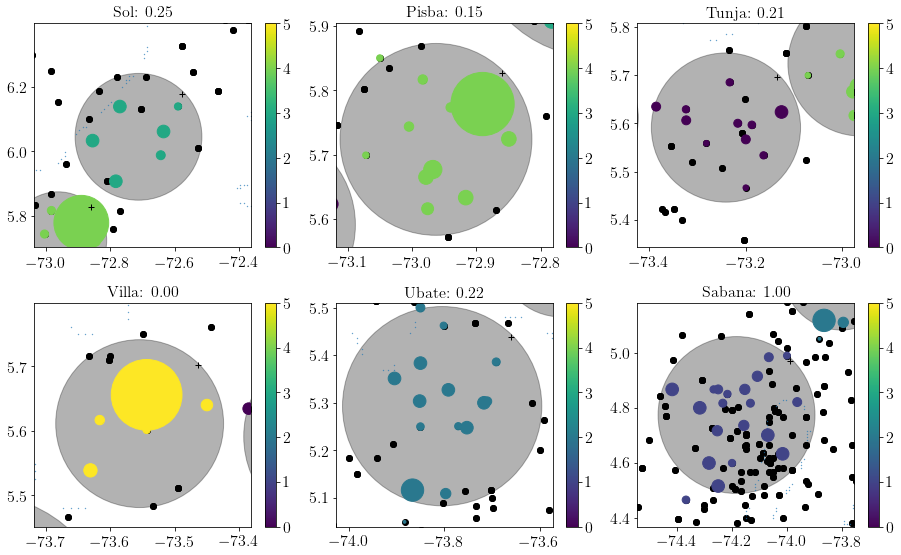

In [380]:
plt.figure(figsize=(13,8))
plt.subplot(2, 3, 1)
plt.scatter(-LonT, -LatT,c='k')
point=np.sqrt(2*r.covars_[:,0])
plt.plot(-r.means_[:,1]+point,-r.means_[:,0]+point,'+k')
plt.scatter(-r.means_[:,1],-r.means_[:,0],s=r.covars_[:,0]*1.8e6,c='k',alpha=0.3)
plt.scatter(colvec[:,0],colvec[:,1],s=0.1)
size=proli[bfilter]*3
plt.scatter(-unifd[:,1],-unifd[:,0],s=size,c=cluster_label_geo)
plt.colorbar()
plt.axis('equal')
plt.axis([-73,-72.4,5.8,6.3])
plt.title("Sol: %.2f" % (2./(6+2)))

plt.subplot(2, 3, 2)
plt.scatter(-LonT, -LatT,c='k')
point=np.sqrt(2*r.covars_[:,0])
plt.plot(-r.means_[:,1]+point,-r.means_[:,0]+point,'+k')
plt.scatter(-r.means_[:,1],-r.means_[:,0],s=r.covars_[:,0]*7e6,c='k',alpha=0.3)
plt.scatter(colvec[:,0],colvec[:,1],s=0.1)
size=proli[bfilter]*4
plt.scatter(-unifd[:,1],-unifd[:,0],s=size,c=cluster_label_geo)
plt.colorbar()
plt.axis('equal')
plt.axis([-73.1,-72.8,5.56,5.9])
plt.title("Pisba: %.2f" % (2./(11+2)))

plt.subplot(2, 3, 3)
plt.scatter(-LonT, -LatT,c='k')
point=np.sqrt(2*r.covars_[:,0])
plt.plot(-r.means_[:,1]+point,-r.means_[:,0]+point,'+k')
plt.scatter(-r.means_[:,1],-r.means_[:,0],s=r.covars_[:,0]*4e6,c='k',alpha=0.3)
plt.scatter(colvec[:,0],colvec[:,1],s=0.1)
size=proli[bfilter]*3
plt.scatter(-unifd[:,1],-unifd[:,0],s=size,c=cluster_label_geo)
plt.colorbar()
plt.axis('equal')
plt.axis([-73.4,-73,5.4,5.75])
plt.title("Tunja: %.2f" % (3./(11+3)))

plt.subplot(2, 3, 4)
plt.scatter(-LonT, -LatT,c='k')
point=np.sqrt(2*r.covars_[:,0])
plt.plot(-r.means_[:,1]+point,-r.means_[:,0]+point,'+k')
plt.scatter(-r.means_[:,1],-r.means_[:,0],s=r.covars_[:,0]*6.9e6,c='k',alpha=0.3)
plt.scatter(colvec[:,0],colvec[:,1],s=0.1)
size=proli[bfilter]*5
plt.scatter(-unifd[:,1],-unifd[:,0],s=size,c=cluster_label_geo)
plt.colorbar()
plt.axis('equal')
plt.axis([-73.7,-73.4,5.5,5.75])
plt.title("Villa: %.2f" % (0))

plt.subplot(2, 3, 5)
plt.scatter(-LonT, -LatT,c='k')
point=np.sqrt(2*r.covars_[:,0])
plt.plot(-r.means_[:,1]+point,-r.means_[:,0]+point,'+k')
plt.scatter(-r.means_[:,1],-r.means_[:,0],s=r.covars_[:,0]*3.8e6,c='k',alpha=0.3)
plt.scatter(colvec[:,0],colvec[:,1],s=0.1)
size=proli[bfilter]*3
plt.scatter(-unifd[:,1],-unifd[:,0],s=size,c=cluster_label_geo)
plt.colorbar()
plt.axis('equal')
plt.axis([-73.95,-73.65,5.04,5.51])
plt.title("Ubate: %.2f" % (4./(14+4)))

plt.subplot(2, 3, 6)
plt.scatter(-LonT, -LatT,c='k')
point=np.sqrt(2*r.covars_[:,0])
plt.plot(-r.means_[:,1]+point,-r.means_[:,0]+point,'+k')
plt.scatter(-r.means_[:,1],-r.means_[:,0],s=r.covars_[:,0]*1.3e6,c='k',alpha=0.3)
plt.scatter(colvec[:,0],colvec[:,1],s=0.1)
size=proli[bfilter]*3
plt.scatter(-unifd[:,1],-unifd[:,0],s=size,c=cluster_label_geo)
plt.colorbar()
plt.axis('equal')
plt.axis([-74.5,-73.8,4.45,5.1])
plt.title("Sabana: %.2f" % (1))

In [325]:
image_name="/home/ecci/Pictures/mwmedianpwv.png"
# map from suen (2016)
im = plt.imread(image_name)
imagesc_name="/home/ecci/Pictures/mwmedpwv_sc_0_80.png"
imsc= plt.imread(imagesc_name)

In [403]:
image_name2="/home/ecci/Pictures/mean_pwv.png"
# map from suen (2014)
im2 = plt.imread(image_name2)
image_name2sc="/home/ecci/Pictures/modmeanpwv_sc_0_25.png"
im2sc = plt.imread(image_name2sc)

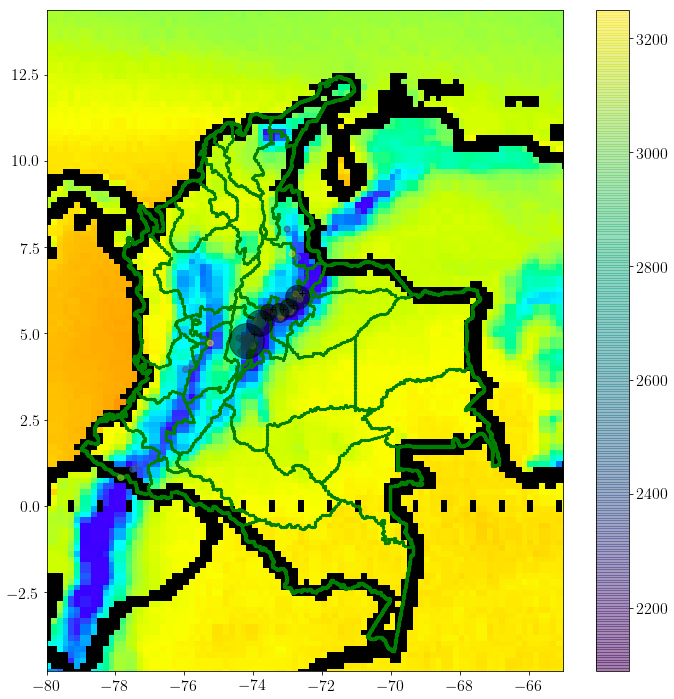

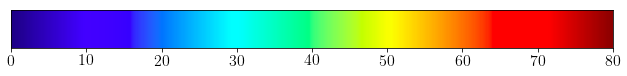

In [412]:
plt.figure(figsize=(10,10))
asc=-0.2
implot = plt.imshow(im,extent=(-90+asc,-59.7+asc,-15,15),interpolation='none')
plt.scatter(colvec[:,0],colvec[:,1],s=10,c='g',lw=0)
#plt.scatter(-LonT, -LatT,c='k',alpha=0.2)

plt.scatter(-filon,-filat,c=altli,alpha=0.5)
plt.colorbar()
plt.plot(-r.means_[:,1]+point,-r.means_[:,0]+point,'+k')

plt.scatter(-r.means_[:,1],-r.means_[:,0],s=r.covars_[:,0]*6.5e4,c='k',alpha=0.5)
plt.axis('equal')
#plt.axis([-78,-72,0.6,9])
plt.axis([-80,-65,0.6,9])

plt.figure(figsize=(9,9))
plt.imshow(imsc,interpolation='none',
            extent=[0,80,0,5])
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left='off',      # ticks along the bottom edge are off
    right='off',         # ticks along the top edge are off
    labelleft='off') 
plt.show()

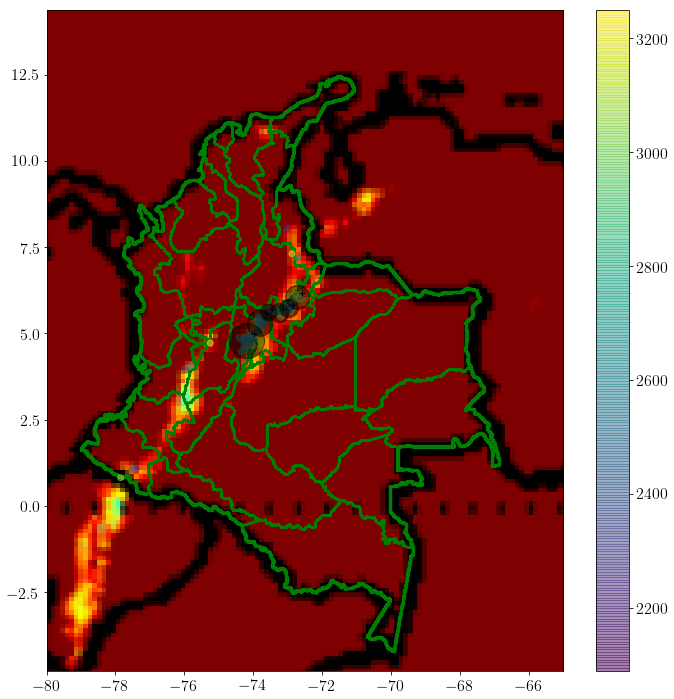

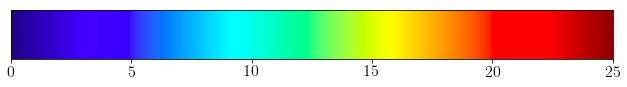

In [429]:
plt.figure(figsize=(10,10))
asc=-0.4
implot = plt.imshow(im2,extent=(-90+asc,-59.7+asc,-15,15),interpolation='none')
plt.scatter(colvec[:,0],colvec[:,1],s=10,c='g',lw=0)
#plt.scatter(-LonT, -LatT,c='k',alpha=0.2)

plt.scatter(-filon,-filat,c=altli,alpha=0.5)
plt.colorbar()
plt.plot(-r.means_[:,1]+point,-r.means_[:,0]+point,'+k')

plt.scatter(-r.means_[:,1],-r.means_[:,0],s=r.covars_[:,0]*6.5e4,c='k',alpha=0.5)
plt.axis('equal')
#plt.axis([-78,-72,0.6,9])
plt.axis([-80,-65,0.6,9])

plt.figure(figsize=(9,9))
plt.imshow(im2sc,interpolation='none',
            extent=[0,25,0,2])
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left='off',      # ticks along the bottom edge are off
    right='off',         # ticks along the top edge are off
    labelleft='off') 
plt.show()

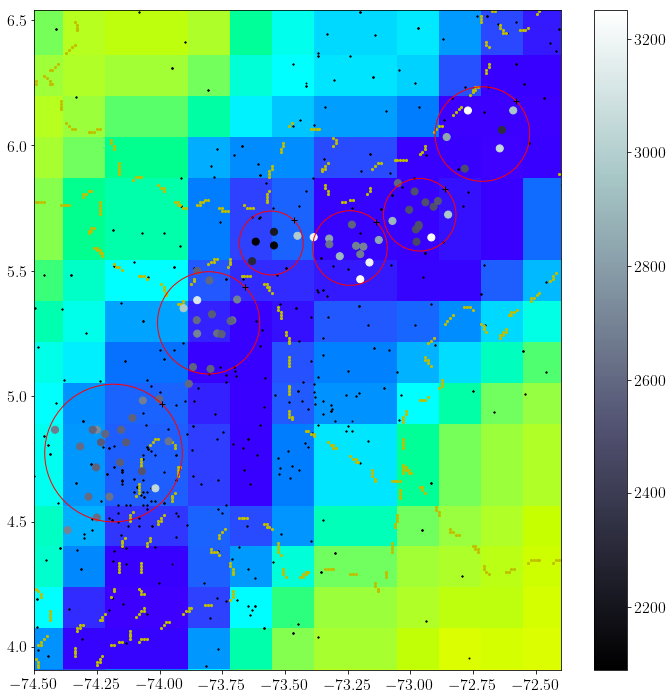

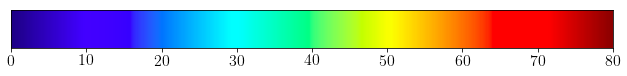

In [398]:
# se necesita haber hecho el gmm final
plt.figure(figsize=(10,10))
asc=-0.2
implot = plt.imshow(im,extent=(-90+asc,-59.7+asc,-15,15),interpolation='none')
plt.scatter(-LonT, -LatT,c='k',s=1)
plt.scatter(colvec[:,0],colvec[:,1],s=10,c='y',lw=0)
plt.scatter(-filon,-filat,c=altli,s=50,cmap='bone')
plt.colorbar()
plt.plot(-r.means_[:,1]+point,-r.means_[:,0]+point,'+k')
plt.scatter(-r.means_[:,1],-r.means_[:,0],s=r.covars_[:,0]*1e6,facecolors='none', edgecolor='r', linewidth='1')
plt.axis('equal')
plt.axis([-74.5,-72.4,4.45,6])
plt.figure(figsize=(9,9))
plt.imshow(imsc,interpolation='none',
            extent=[0,80,0,5])
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left='off',      # ticks along the bottom edge are off
    right='off',         # ticks along the top edge are off
    labelleft='off') 
plt.show()

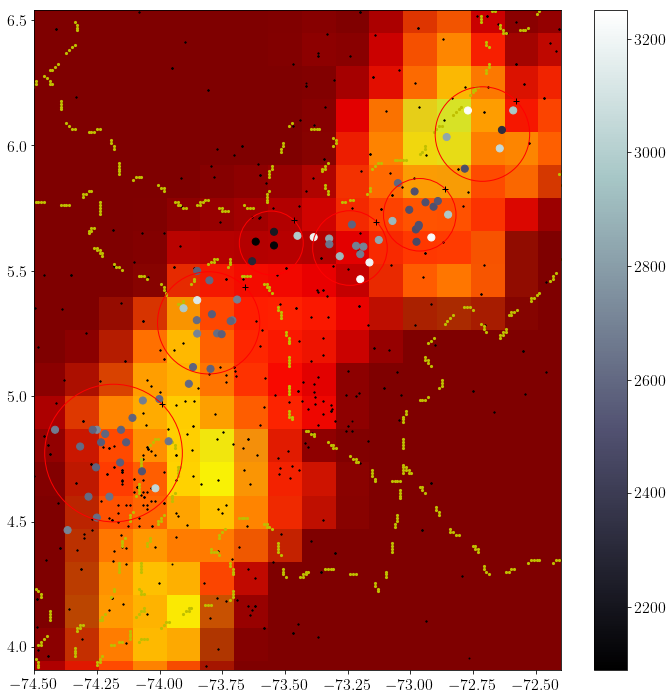

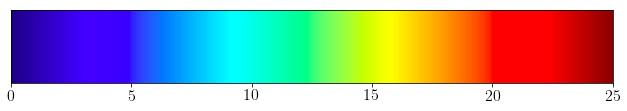

In [434]:
# en este es mucho menos claro
plt.figure(figsize=(10,10))
implot = plt.imshow(im2,extent=(-90-0.4,-59.7-0.4,-15,15),interpolation='none')
#implot = plt.imshow(im,extent=(-90+asc,-59.7+asc,-15,15),interpolation='none',alpha=0.2)

plt.scatter(-LonT, -LatT,c='k',s=1)
plt.scatter(colvec[:,0],colvec[:,1],s=10,c='y',lw=0)
plt.scatter(-filon,-filat,c=altli,s=50,cmap='bone')
plt.colorbar()
plt.plot(-r.means_[:,1]+point,-r.means_[:,0]+point,'+k')
plt.scatter(-r.means_[:,1],-r.means_[:,0],s=r.covars_[:,0]*1e6,facecolors='none', edgecolor='r', linewidth='1')
plt.axis('equal')
plt.axis([-74.5,-72.4,4.45,6])
plt.figure(figsize=(9,9))
plt.imshow(im2sc,interpolation='none',
            extent=[0,25,0,3])
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left='off',      # ticks along the bottom edge are off
    right='off',         # ticks along the top edge are off
    labelleft='off') 
plt.show()

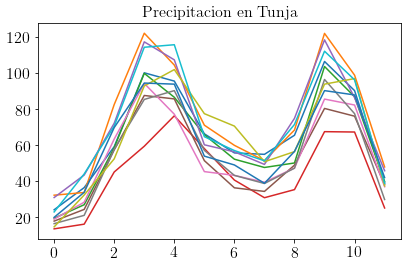

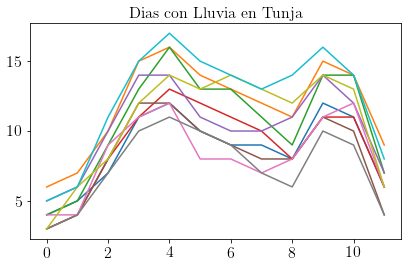

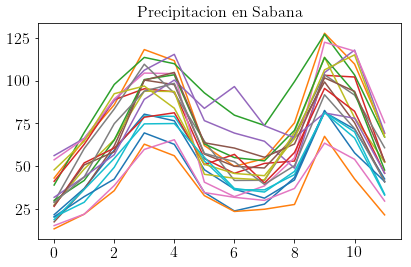

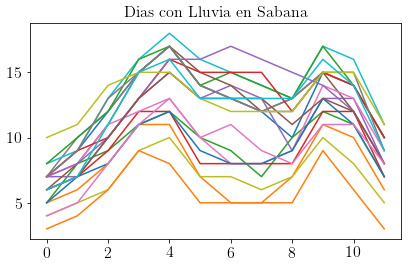

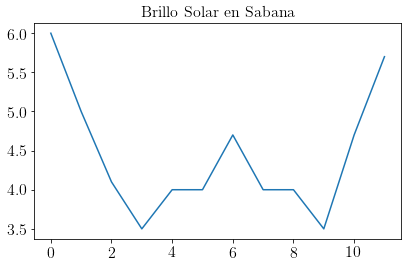

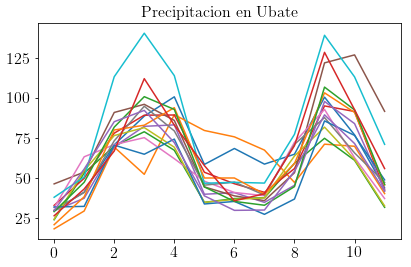

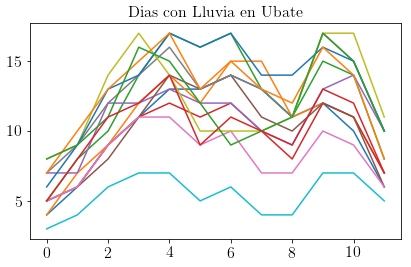

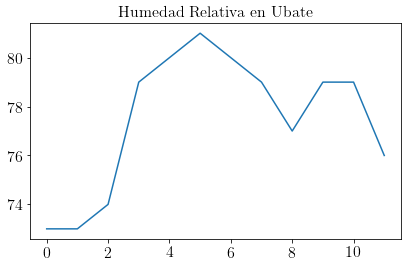

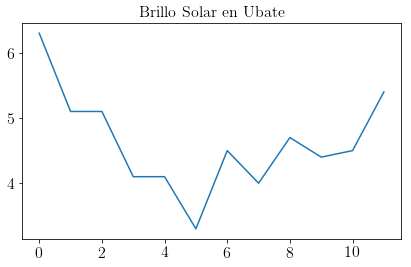

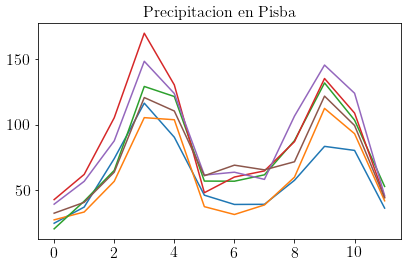

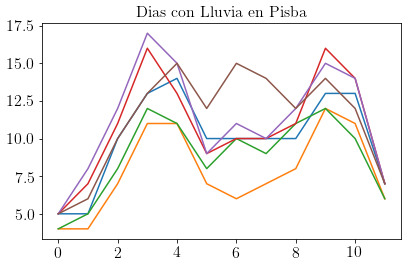

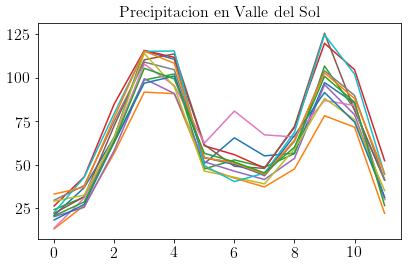

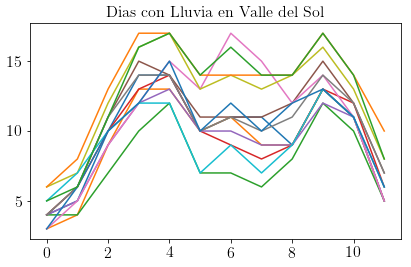

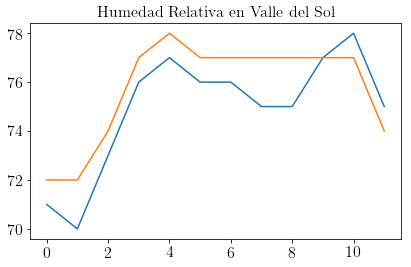

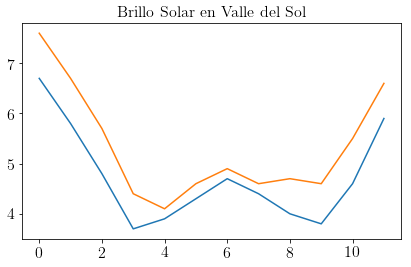

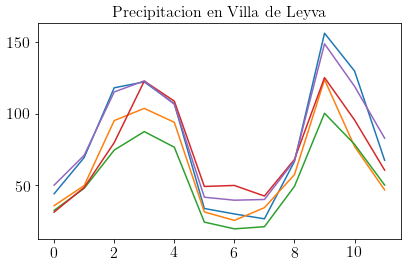

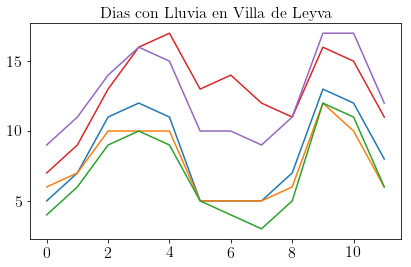

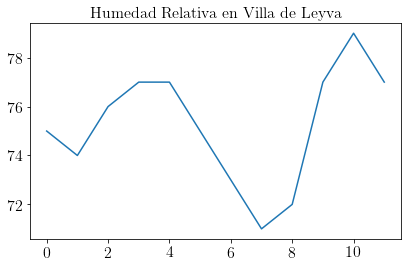

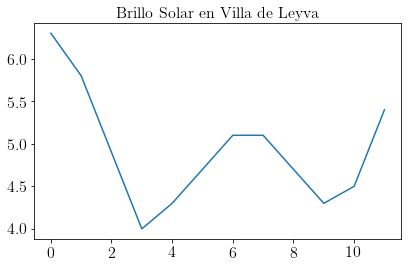

In [473]:
x=np.arange(12)
names=['Tunja','Sabana','Ubate','Pisba','Valle del Sol','Villa de Leyva']
for k in np.arange(dftot.clno.max()+1):
    dftemp=dftot[dftot.clno==k]
    for i in dftemp.code[dftemp.lmean>0]:
        plt.plot(x,df0[df0.CODIGO==i][[ 'ENE','FEB','MAR','ABR','MAY','JUN','JUL','AGO','SEP','OCT','NOV','DIC']].as_matrix()[0])
    plt.title("Precipitacion en %s" %names[k])
    plt.show()
    for i in dftemp.code[dftemp.dmean>0]:
        plt.plot(x,df1[df1.CODIGO==i][[ 'ENE','FEB','MAR','ABR','MAY','JUN','JUL','AGO','SEP','OCT','NOV','DIC']].as_matrix()[0])
    plt.title("Dias con Lluvia en %s" %names[k])
    plt.show()
    if (dftemp.hmean>0).sum() >0 :
        for i in dftemp.code[dftemp.hmean>0]:
            plt.plot(x,df2[df2.CODIGO==i][[ 'ENE','FEB','MAR','ABR','MAY','JUN','JUL','AGO','SEP','OCT','NOV','DIC']].as_matrix()[0])
        plt.title("Humedad Relativa en %s" %names[k])
        plt.show()
    if (dftemp.bmean>0).sum() >0 :
        for i in dftemp.code[dftemp.bmean>0]:
            plt.plot(x,df3[df3.CODIGO==i][[ 'ENE','FEB','MAR','ABR','MAY','JUN','JUL','AGO','SEP','OCT','NOV','DIC']].as_matrix()[0])
        plt.title("Brillo Solar en %s" %names[k])
        plt.show()

# Correr al final si es necesario

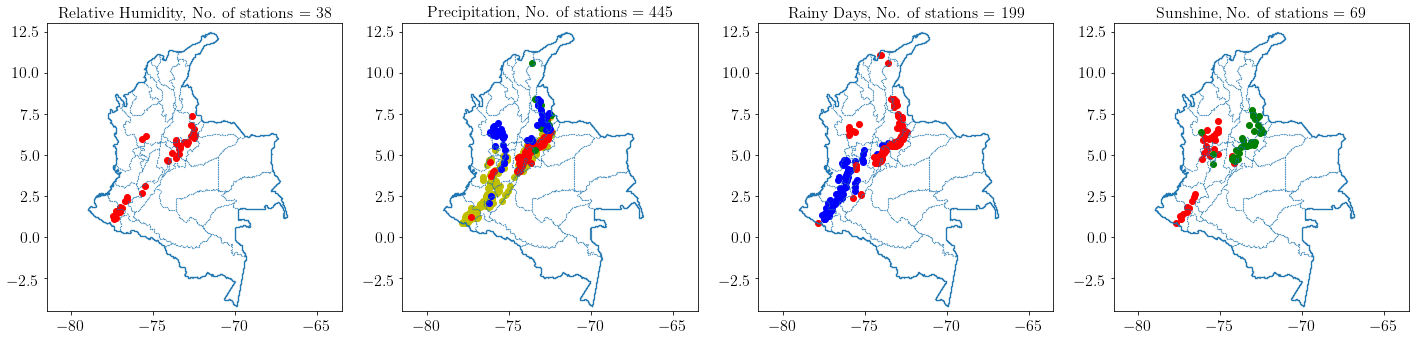

In [27]:
# No hace falta correr esta parte para el paper, esto se uso para el poster
# Graficamos los clusters seleccionados con el filtro de alturas > 1500 msnm, esto es sólo para la visualización
# Muchas de estas estaciones a pesar de cumplir uno de los criterios no necesariamente cumplen todos
# El orden de importancia es RGBY
plt.figure(figsize=(20,5))

plt.subplot(1, 4, 1)
# Nos interesa el 1
filter1=ALTH[:,1]>1500
plt.scatter(-LONH[:,1][filter1],-LATH[:,1][filter1],c='r')
plt.scatter(colvec[:,0],colvec[:,1],s=0.01)
plt.axis('equal')
plt.axis([-80,-65,-4.5,13])
plt.title("Relative Humidity, No. of stations = %i" % filter1.sum())

plt.subplot(1, 4, 2)
# Nos interesa el 1, 4, 6 y 10
filter1=ALTL[:,1]>1500
filter4=ALTL[:,4]>1500
filter6=ALTL[:,6]>1500
filter10=ALTL[:,10]>1500
plt.scatter(-LONL[:,10][filter10],-LATL[:,10][filter10],c='y')
plt.scatter(-LONL[:,1][filter1],-LATL[:,1][filter1],c='r')
plt.scatter(-LONL[:,4][filter4],-LATL[:,4][filter4],c='g')
plt.scatter(-LONL[:,6][filter6],-LATL[:,6][filter6],c='b')
plt.scatter(colvec[:,0],colvec[:,1],s=0.01)
plt.axis('equal')
plt.axis([-80,-65,-4.5,13])
plt.title("Precipitation, No. of stations = %i" % (filter1.sum()+filter4.sum()+filter6.sum()+filter10.sum()))

plt.subplot(1, 4, 3)
# Nos interesa el 0, 3 y 5
# Del 0 solo hay una estacion sobre 1500 msm
filter0=ALTD[:,0]>1500
filter3=ALTD[:,3]>1500
filter5=ALTD[:,5]>1500
plt.scatter(-LOND[:,0][filter0],-LATD[:,0][filter0],c='g')
plt.scatter(-LOND[:,3][filter3],-LATD[:,3][filter3],c='b')
plt.scatter(-LOND[:,5][filter5],-LATD[:,5][filter5],c='r')
plt.scatter(colvec[:,0],colvec[:,1],s=0.01)
plt.axis('equal')
plt.axis([-80,-65,-4.5,13])
plt.title("Rainy Days, No. of stations = %i" % (filter0.sum()+filter3.sum()+filter5.sum()))

plt.subplot(1, 4, 4)
# Nos interesan el 0, 3 y 4
# El 3 no tiene datos por encima de 1500 msnm (aunque es el que mas nos gusta)
filter4=ALTB[:,4]>1500
filter0=ALTB[:,0]>1500
plt.scatter(-LONB[:,0][filter0],-LATB[:,0][filter0],c='r')
plt.scatter(-LONB[:,4][filter4],-LATB[:,4][filter4],c='g')
plt.scatter(colvec[:,0],colvec[:,1],s=0.01)
plt.axis('equal')
plt.axis([-80,-65,-4.5,13])
plt.title('Sunshine, No. of stations = %i' % (filter0.sum()+filter4.sum()))
# principal: 2 secundario 0

665


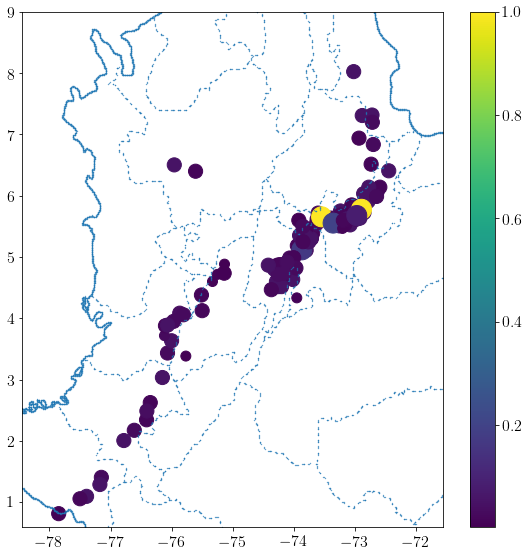

In [435]:
# primer shortlist con 665 estaciones
plt.figure(figsize=(8,8))
filter=EST[:,4][critfilter]>2000
plt.scatter(-EST[:,2][critfilter][filter],-EST[:,3][critfilter][filter],c=probof[critfilter][filter],s=100*EST[:,0][critfilter][filter])
plt.colorbar()
plt.scatter(colvec[:,0],colvec[:,1],s=0.1)
plt.axis('equal')
plt.axis([-78,-72,0.6,9])
print critfilter.sum()

# No correr (tarda mucho)

In [62]:
# Revisamos consistencia por proximidad
# Toma tiempo, no es necesario hacer de nuevo
filelist=['lluvia.csv','diaslluvia.csv','humedad.csv','brillo.csv']
distlimit=3
alimit=100
for f in filelist:
    if f[0]=='l':
        df=df0    
    if f[0]=='d':
        df=df1
    if f[0]=='h':
        df=df2
    if f[0]=='b':
        df=df3
    co=0
#    df=df0
    qarray=np.zeros((len(df),6))
    for i in np.asarray(df.CODIGO):
        mylat=conversion(df.LATITUD[df.CODIGO==i].iloc[0])
        mylon=conversion(df.LONGITUD[df.CODIGO==i].iloc[0])
        distarr=np.array([])
        for kki in range(len(df)):
            distarr=np.append(distarr,np.sqrt((conversion(df.LATITUD.iloc[kki])-mylat)**2+(conversion(df.LONGITUD.iloc[kki])-mylon)**2))
        distarr[distarr==0]=100.
        codi=df.CODIGO.iloc[np.argmin(distarr)]
        if distarr.min()*111.25 < distlimit and np.abs(df.ELEV[df.CODIGO==i].iloc[0]-df.ELEV[df.CODIGO==codi].iloc[0]) < alimit:        
            datamonth=(df.as_matrix(columns=df.columns[8:20]))[np.argmax(df.CODIGO==i)]
            datacomp=(df.as_matrix(columns=df.columns[8:20]))[np.argmax(df.CODIGO==codi)]
            qarray[co]=np.array([distarr.min()*111.25,codi,i,(np.abs(datamonth-datacomp)/datamonth).mean()*100.,df.ELEV[df.CODIGO==i].iloc[0]-df.ELEV[df.CODIGO==codi].iloc[0],100*np.abs(datamonth.mean()-datacomp.mean())/datamonth.mean()])
            co+=1
    qarray1=qarray[(qarray[:,0]!=0)]
# Aqui estan la diferencia entre los valores medios y el promedio de las diferencias entre los valores.
    print "Mean Rel. Error: ",qarray1[:,5].mean(),qarray1[:,3].mean(), ", Mean dist. (km): ", qarray1[:,0].mean()
    col1=np.sort(qarray1[:,1:3])[:,0].astype(int).astype('str')
    col2=np.sort(qarray1[:,1:3])[:,1].astype(int).astype('str')
    concar=np.unique(np.core.defchararray.add(col1,col2))
    print "Unique pairs:", concar.shape[0],"for data in: ", f
    print " "
    par1=np.array([])
    par2=np.array([])
    for i in concar:
        par1=np.append(par1,int(i[0:8]))
        par2=np.append(par2,int(i[8:]))
    distlist=zip(par1,par2)

KeyboardInterrupt: 

# Desde aqui, mapa general

In [181]:
# Alex Amaral-Rogers' Gaussian Kernel Contour generator
#returns the co-added gaussian kernels grid, and an array of numbers equaling the levels corresponding to the input sigma array.

#the inputs to the function is
#x = array of x data
#y = array of y data (must be the same size as x)
#x1,x2, y1,y2 the limits of the region in which you wish the plot to be.
#N the number of grid points in the axis. You can change this to be Nx, Ny if you preferred.
#sig = list of contour levels you want to plot in terms of sigma levels i.e. [0.5, 1, 2.0] is 0.5 sigma, 1 sigma, 2 sigma levels.


from scipy.stats import gaussian_kde
from scipy.special import erf

def CONTOURP(x, x1, x2, y, y1, y2, N, sig):
    xx = np.linspace(x1, x2, N)
    yy = np.linspace(y1, y2, N)

    XX, YY = np.meshgrid(xx, yy)
    values = np.vstack([x, y])
    positions = np.vstack([XX.ravel(), YY.ravel()])
    kernel = gaussian_kde(values)
    f = np.reshape(kernel(positions).T, XX.shape)

    PCT = 1.0 - np.cumsum(np.sort(f.ravel()))/np.sum(f)
    NN = np.sort(f.ravel())
    SO = [ ]
    for s in sig:
        SO += [NN[(np.abs(PCT - erf(s/np.sqrt(2.0)))).argmin()]]

    return f, SO

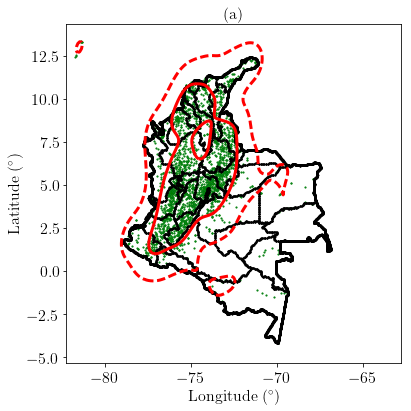

In [187]:
reso=300
# Obtenemos los datos para hacer el contorno de densidad de datos
lnmin=-85
lnmax=-65
ltmin=-5
ltmax=14
nmesh=200
sigarray=[2.,1.]
CONT=CONTOURP(-EST[:,2],lnmin,lnmax,-EST[:,3],ltmin,ltmax,nmesh,sigarray);
xmesh=np.linspace(lnmin,lnmax,nmesh)
ymesh=np.linspace(ltmin,ltmax,nmesh)
Xmesh,Ymesh=np.meshgrid(xmesh,ymesh)
# contornos + azules= todas las estaciones dentro de sigarray=1,2 sigma
# rojos = cumplen al menos una de nuestras condiciones
plt.figure(figsize=(6,6))
origin = 'lower'
plt.contour(Xmesh,Ymesh,CONT[0], levels = CONT[1],linewidths=3,colors=('red'),linestyles=('dashed','solid'))
plt.scatter(-LonT, -LatT,s=1,alpha=0.7, edgecolor='g')
#plt.scatter(-DATT[:,1],-DATT[:,2],c='r')
plt.scatter(colvec[:,0],colvec[:,1],s=1,c='k')
plt.xlim(-80,-65)
plt.ylim(-5,13)
plt.xlabel(r"Longitude ($^\circ$)")
plt.ylabel(r"Latitude ($^\circ$)")
plt.title("(a)")
plt.axis('equal')
plt.axis([-80,-65,-5,14])
plt.savefig('pasp/totmap.eps', dpi=reso)
plt.savefig('pasp/totmap.pdf', dpi=reso)